In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import fbprophet 
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from fbprophet.diagnostics import cross_validation, performance_metrics
# don't do this at home
warnings.filterwarnings("ignore")

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
# def validate():
"""
>> takes in 
    > Census 1970-2010 dataframe (1 df)
        >> total population by Place measurements
    > American Community Survey (ACS) 2011-2017 dataframes (7 dfs)
        >> total population (age & sex) by Place 

>> forges DataFrame of places that have 
    > at least one (1) recording for Census years 1970-2010
    > at least one (1) recording for ACS years 2011-2015

>> test our model v. base on
    > random sample 100 Places
    > random sample 100 Places from bottom half population size
    > random sample 100 Places from top half population size
"""

'''load Train data'''
# population by Place Census 1970-2010 measurements
load_census_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''load Test data'''
# population by Place ACS 2016
load_acs_20l6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2017
load_acs_20l7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 

'''find common places across Census and each train ACS'''
# identify Places measured in 2011 ACS [0 == 'Geography'] (# 29517)
acs11places = [place for place in load_acs_20l1['GEO.display-label'][1:]]
# identify Places measured in 2012 ACS  (# 29510)
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS (# 29510)
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS (# 29550)
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS (# 29575)
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

# cross 2011-2015, keep coexisting Places (# 29475)
train_places = [place for place in acs11places if place in acs12places and acs13places and acs14places and acs15places]

"""find common places across 2016 & 2017 (test ACSs)
"""
# identify Places measured in 2016 ACS (# 29574) [0 == 'Geography']
acs16places = [place for place in load_acs_20l6['GEO.display-label'][1:]]
# identify Places measured in 2017 ACS (# 29577)
acs17places = [place for place in load_acs_20l7['GEO.display-label']]

# cross 2017 Places w/ 2016 Places, keep coexisting Places (# 29550)
base_places = [place for place in acs17places if place in acs16places]

"""find common Places across the Places our model will train on {train_places} 
    and the Places our model can predict on {base_places}
"""
# identify Places we can compare our predictions with (# 29341)
pre_measureable_places = [place for place in train_places if place in base_places]

"""clean Census 1970-2010 df (Train)
"""
# identify columns needed to make GEO.display-label column (so can pair with ACS DataFrames) 
for_geo_displays = ['PLACE','STATE']
# pull those columns 
to_geo_displays = load_census_place[for_geo_displays]

# mold PLACE column into list with Place formatted as is in GEO.display-label
places_70_10 = [place + ', ' for place in to_geo_displays.PLACE]

# list paired State for each Place
states_70_10 = [state for state in to_geo_displays.STATE]

# merge places_70_10 and states_70_10 into list formatted as GEO.display-label column
GEO_display_label = [ places_70_10[i] + states_70_10[i] for i in range(len(places_70_10))]

# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']
# set base dataframe using Census (1970-2010) measurements 
pop_place_70_10_ = load_census_place[place_cols_of_interest]

# add GEO.display-label column from GEO_display_label list (# 31436)
pop_place_70_10_['GEO.display-label'] = GEO_display_label

# forget places without measurements for at least 3 of the 5 census measurement years (# 23027)
at_least_3_70_10_ = pop_place_70_10_.dropna(axis=0) #,thresh=4)
# forget places with measurements of 0 for 2000 (# 23018)
not_0_for_2000_ = at_least_3_70_10_.loc[at_least_3_70_10_.AV0AA2000 != 0]
# forget places with measurements of 0 for 2010 (# 23016)
pop_place_70_10_ = not_0_for_2000_.loc[not_0_for_2000_.AV0AA2010 != 0]

# note the remaining places (total # = 23016)
census_places = [place for place in pop_place_70_10_['GEO.display-label']]
# adjust measurable places to reflect places with census measurements (total # = 22506)
measureable_places = [place for place in pre_measureable_places if place in census_places]

"""clean American Community Survey (ACS) 2011-2015 dataframes (Train)
"""
# ID columns we will be using
columns = ['GEO.display-label', 'HC01_EST_VC01']
# convert 2011
acs_20l1 = load_acs_20l1[columns]
# convert 2012
acs_20l2 = load_acs_20l2[columns]
# convert 2013
acs_20l3 = load_acs_20l3[columns]
# convert 2014
acs_20l4 = load_acs_20l4[columns]
# convert 2015
acs_20l5 = load_acs_20l5[columns]

"""convert Train years to reflect Places only seen in measureable_places
"""
# drop Census Places not ideal for measurement (29346)
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2011_place_populations = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(measureable_places)]
# drop 2012 ACS Places not ideal for measurement (29341)
acs_2012_place_populations = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(measureable_places)]
# drop 2013 ACS Places not ideal for measurement (29341) 
acs_2013_place_populations = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(measureable_places)]
# drop 2014 ACS Places not ideal for measurement (29341) 
acs_2014_place_populations = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(measureable_places)]
# drop 2015 ACS Places not ideal for measurement (29341) 
acs_2015_place_populations = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(measureable_places)]

"""clean ACS 2016 & 2017 dataframes (Test)
    take a sample of n Places to score our model
"""
# identify 2016/2017 columns of interest (to measure against)
test_col_of_i = ['GEO.display-label', 'HC01_EST_VC01']

# shrink ACS 2017 df to columns to measure against only 
testd_16_ = load_acs_20l6[test_col_of_i]
# realize ACS 2016 combined measureable_places DataFrame (Baseline) dataframe 
test_16_df_ = testd_16_.loc[testd_16_['GEO.display-label'].isin(measureable_places)]

# shrink ACS 2017 df to columns to measure against only 
testd_17_ = load_acs_20l7[test_col_of_i]
# realize ACS 2017 combined measureable_places DataFrame (Baseline) dataframe 
test_17_df_ = testd_17_.loc[testd_17_['GEO.display-label'].isin(measureable_places)]
# conver
test_17_1000_pops = [float(population) for population in test_17_df_.HC01_EST_VC01]
# convert test_17_df_ populations to floats (numbers, from strings) 
test_17_df_.HC01_EST_VC01 = test_17_1000_pops
# forget Places with 2017 measured population less than 1,000 (13218 places remain)
test_17_df_ = test_17_df_.loc[test_17_df_.HC01_EST_VC01 >= 1000]

"""# locate and pull cities of interest
city_sfo = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'San Francisco city, California']
city_nyc = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New York city, New York']
city_nola = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New Orleans city, Louisiana']
city_houston = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Houston city, Texas']
city_bville = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Bentonville city, Arkansas']
city_sidney = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Sidney city, Nebraska']
city_pleasanton = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Pleasanton city, California']
sample_one_hunnit = pd.concat([city_sfo,city_nyc,city_nola,city_houston,city_bville,city_sidney,city_pleasanton])
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]"""

"# locate and pull cities of interest\ncity_sfo = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'San Francisco city, California']\ncity_nyc = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New York city, New York']\ncity_nola = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New Orleans city, Louisiana']\ncity_houston = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Houston city, Texas']\ncity_bville = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Bentonville city, Arkansas']\ncity_sidney = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Sidney city, Nebraska']\ncity_pleasanton = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Pleasanton city, California']\nsample_one_hunnit = pd.concat([city_sfo,city_nyc,city_nola,city_houston,city_bville,city_sidney,city_pleasanton])\n# list Places for conversion of other Datas\nsample_places = [place for place in sample_one_hunnit['GEO.display-label']]"

In [3]:
# sample Baseline data for Places to evaluate model 
sample_one_hunnit = test_17_df_.sample(100)
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]

In [32]:
sample_places

['Laplace CDP, Louisiana',
 'Paramus borough, New Jersey',
 'Munroe Falls city, Ohio',
 'Fountain Inn city, South Carolina',
 'Hillsdale village, Missouri',
 'Cloverdale city, California',
 'Bluefield town, Virginia',
 'Eden CDP, New York',
 'La Fayette city, Alabama',
 'Canton city, Illinois',
 'Affton CDP, Missouri',
 'Frostproof city, Florida',
 'Livingston city, California',
 'Wisconsin Rapids city, Wisconsin',
 'Bellmead city, Texas',
 'Everett city, Massachusetts',
 'San Rafael city, California',
 'Colonial Heights city, Virginia',
 'Pikesville CDP, Maryland',
 'Philipsburg borough, Pennsylvania',
 'Bridgeport village, Ohio',
 'North Little Rock city, Arkansas',
 'Reading city, Pennsylvania',
 'Grandview Heights city, Ohio',
 'Corunna city, Michigan',
 'Plymouth CDP, Massachusetts',
 'Idaho Falls city, Idaho',
 'Mahtomedi city, Minnesota',
 'Punta Gorda city, Florida',
 'San Lorenzo CDP, California',
 'Great Barrington CDP, Massachusetts',
 'Yorba Linda city, California',
 'Bridg

In [4]:
"""adjust Train dataframes to sampled Places
"""
# shrink Census DataFrame to sampled Places
_s_census_ = census_place_populations.loc[census_place_populations['GEO.display-label'].isin(sample_places)]
# shrink 2011 ACS df to sampled Places 
_s_acs_2011_ = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(sample_places)]
# shrink 2012 ACS DataFrame to sampled Places 
_s_acs_2012_ = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(sample_places)]
# shrink 2013 ACS df to Places in sample  
_s_acs_2013_ = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(sample_places)]
# shrink 2014 ACS DataFrame to sampled Places 
_s_acs_2014_ = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(sample_places)]
# shrink 2015 ACS df to sampled Places 
_s_acs_2015_ = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(sample_places)]

"""adjust Test dataframes to sampled Places
"""
# 2016 ACS df to sampled Places 
test_16_df = test_16_df_.loc[test_16_df_['GEO.display-label'].isin(sample_places)]
# reset 2016 ACS df index
test_16_df = test_16_df.set_index(test_16_df['GEO.display-label'])

# 2017 ACS DataFrame to sampled Places 
test_17_df = test_17_df_.loc[test_17_df_['GEO.display-label'].isin(sample_places)]
# reset 2017 ACS df index
test_17_df = test_17_df.set_index(test_17_df['GEO.display-label'])

"""forge combined Train/Test DataFrame 
    --ensure Place order remains unchanged
"""
# set Census index to Places, and forget Place column 
s_census_ = _s_census_.copy().set_index(_s_census_['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# rename Census columns to years for later datetime conversion
s_census_.columns = ['1970','1980','1990','2000','2010']

# set 2011 index to Places 
s_acs_2011_ = _s_acs_2011_.copy().set_index(_s_acs_2011_['GEO.display-label'])
# rename columns 
s_acs_2011_.columns = ['no','2011']
# only continue with year/measurement column
s_acs_2011_ = s_acs_2011_['2011']

# set 2012 index to Places 
s_acs_2012_ = _s_acs_2012_.copy().set_index(_s_acs_2012_['GEO.display-label'])
# rename columns 
s_acs_2012_.columns = ['no','2012']
# only continue with year/measurement column
s_acs_2012_ = s_acs_2012_['2012']

# set 2013 index to Places 
s_acs_2013_ = _s_acs_2013_.copy().set_index(_s_acs_2013_['GEO.display-label'])
# rename columns 
s_acs_2013_.columns = ['no','2013']
# only continue with year/measurement column
s_acs_2013_ = s_acs_2013_['2013']

# set 2014 index to Places 
s_acs_2014_ = _s_acs_2014_.copy().set_index(_s_acs_2014_['GEO.display-label'])
# rename columns 
s_acs_2014_.columns = ['no','2014']
# only continue with year/measurement column
s_acs_2014_ = s_acs_2014_['2014']

# set 2015 index to Places 
s_acs_2015_ = _s_acs_2015_.copy().set_index(_s_acs_2015_['GEO.display-label'])
# rename columns 
s_acs_2015_.columns = ['no','2015']
# only continue with year/measurement column
s_acs_2015_ = s_acs_2015_['2015']

# rename columns 
test_16_df.columns = ['no','2016']
# only continue with year/measurement column
test_16_df = test_16_df['2016']

# rename columns 
test_17_df.columns = ['no','2017']
# only continue with year/measurement column
test_17_df = test_17_df['2017']

# forge Train DataFrame and convert NaN values to 0 (assumes population not measured is 0) 
combined_df = pd.concat([s_census_,s_acs_2011_,s_acs_2012_,s_acs_2013_,s_acs_2014_,s_acs_2015_,test_16_df,test_17_df],axis=1).fillna(0)

# split train_df from combined_df
train_df = combined_df[['1970', '1980', '1990', '2000', '2010', '2011', '2012', '2013', '2014','2015','2016']]
# split test_df form combined_df
test_df = combined_df[['2016', '2017']]

INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.


INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 

INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.


INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2009-02-01 00:00:00 and 2015-01-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.


INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


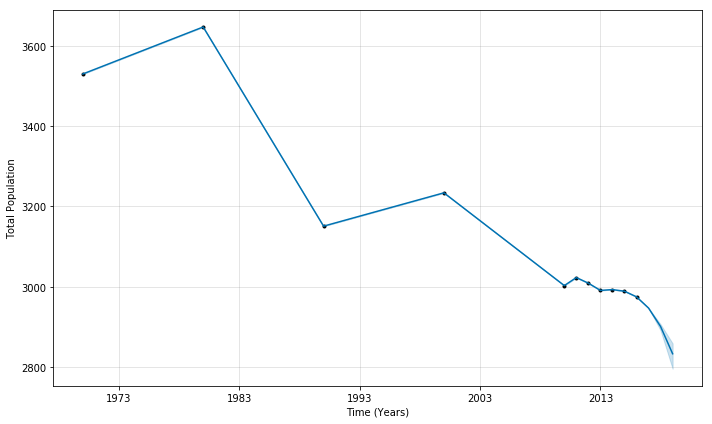

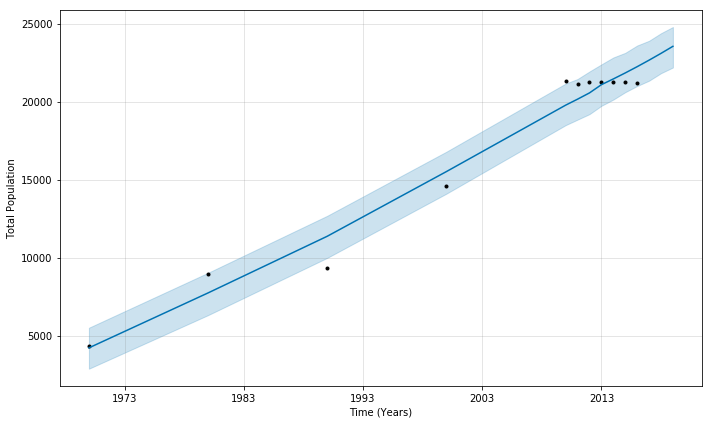

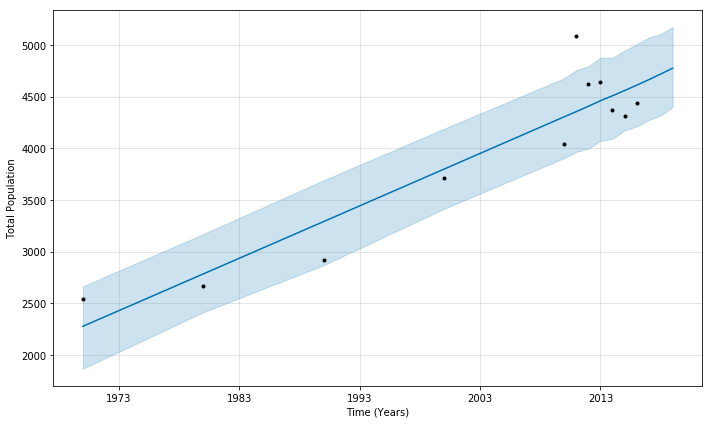

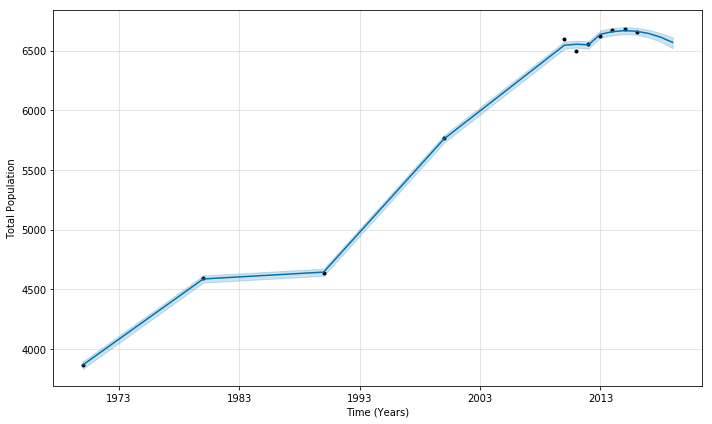

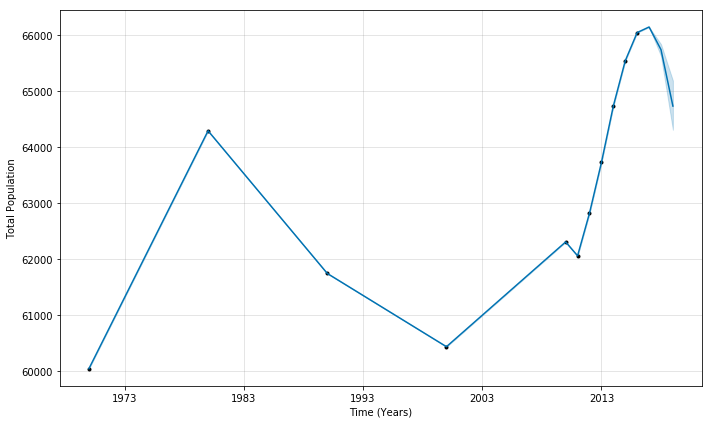

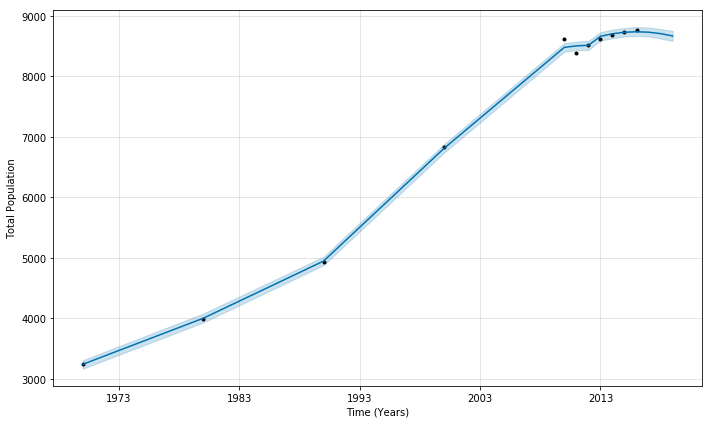

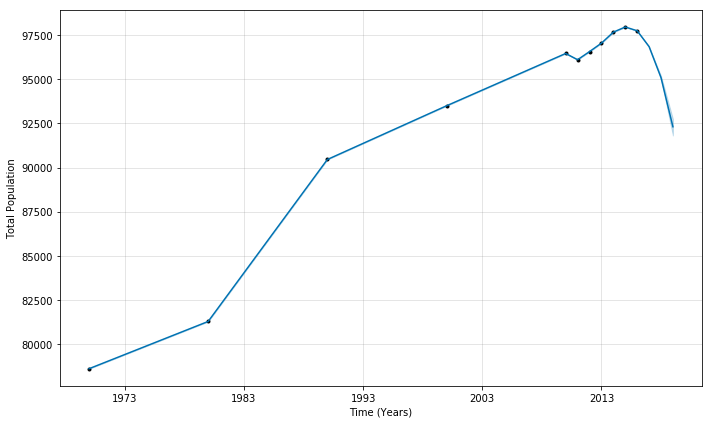

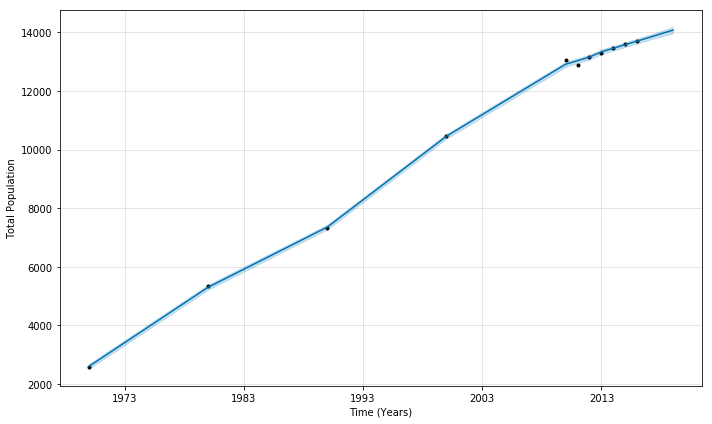

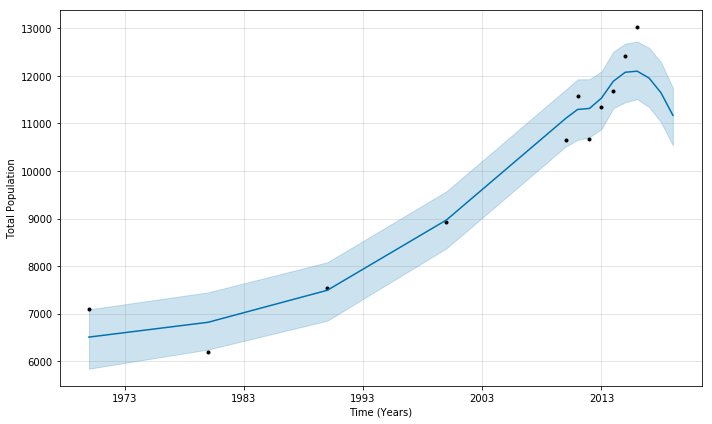

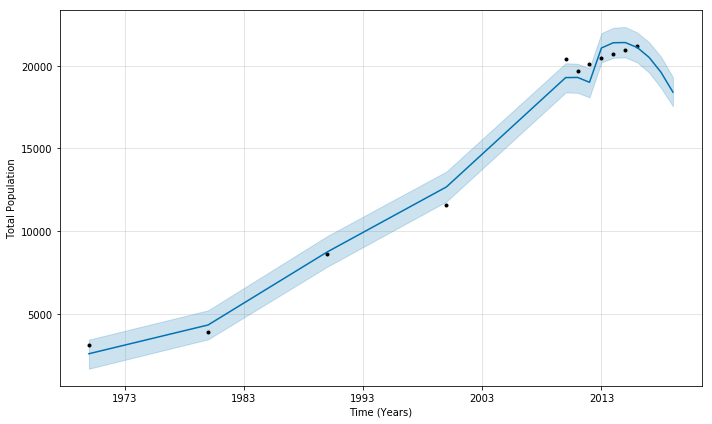

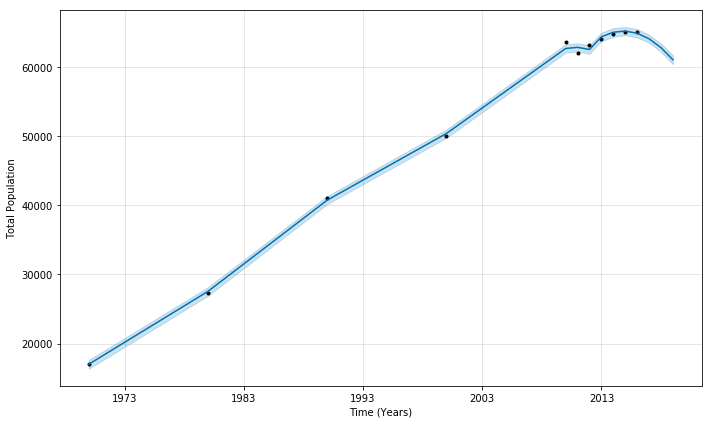

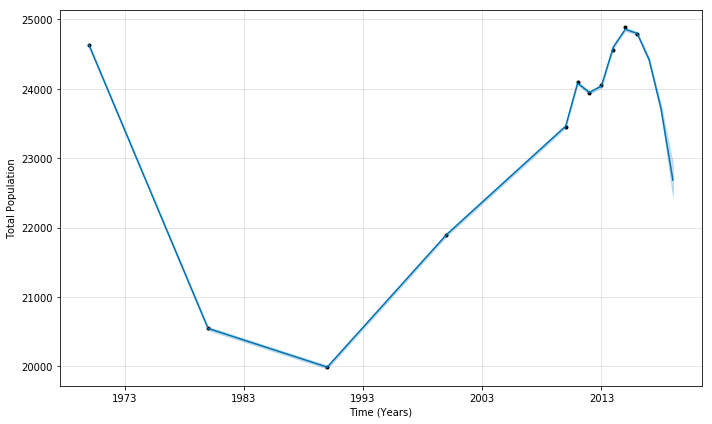

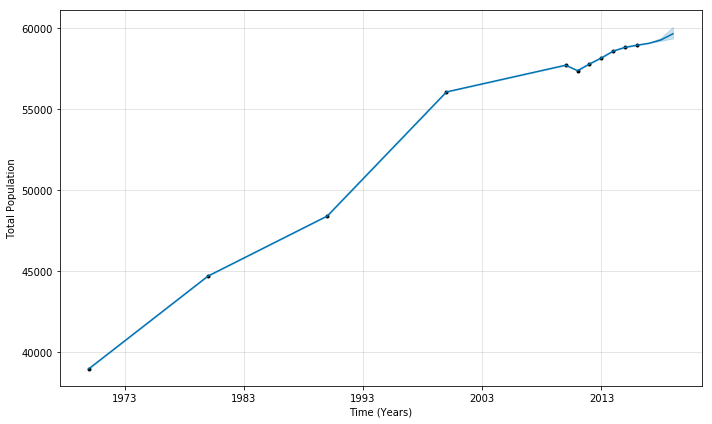

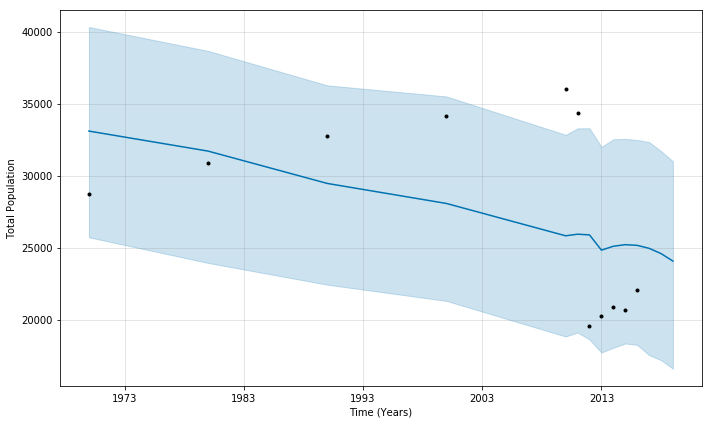

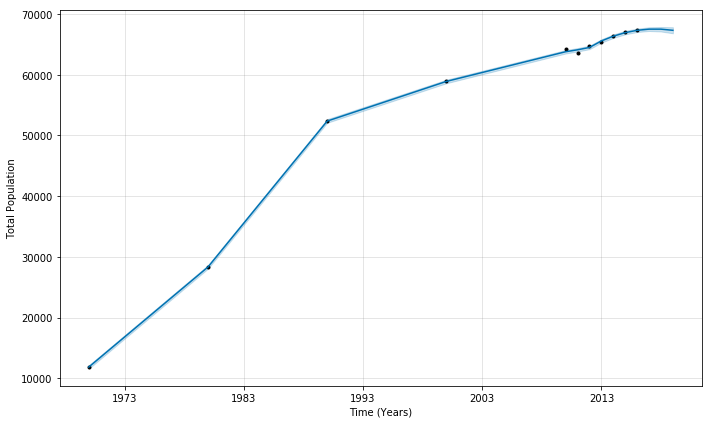

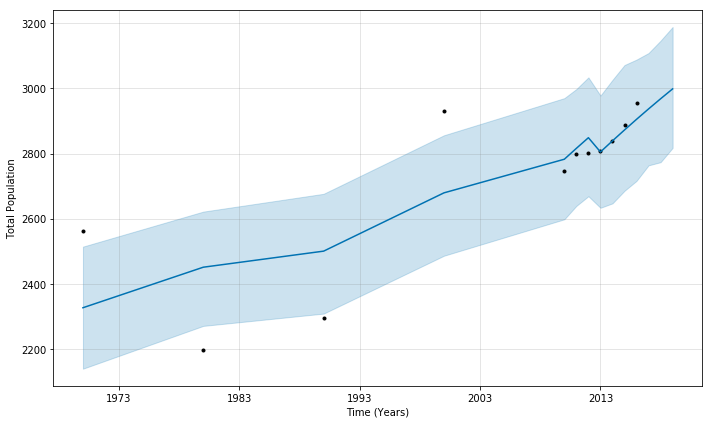

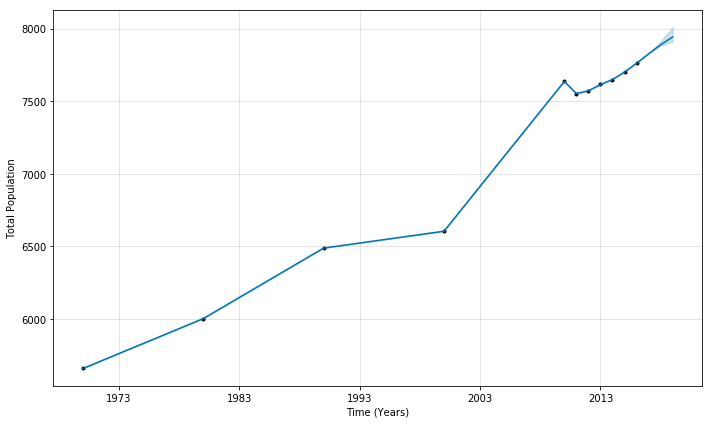

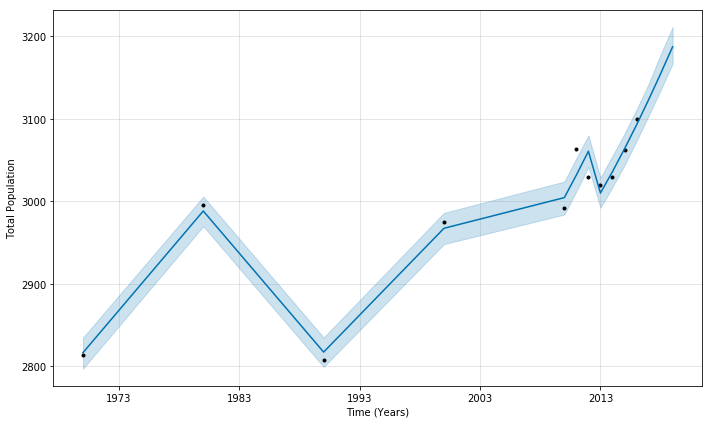

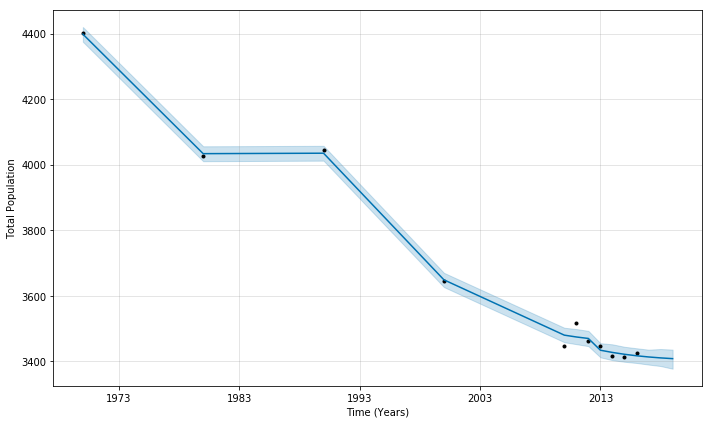

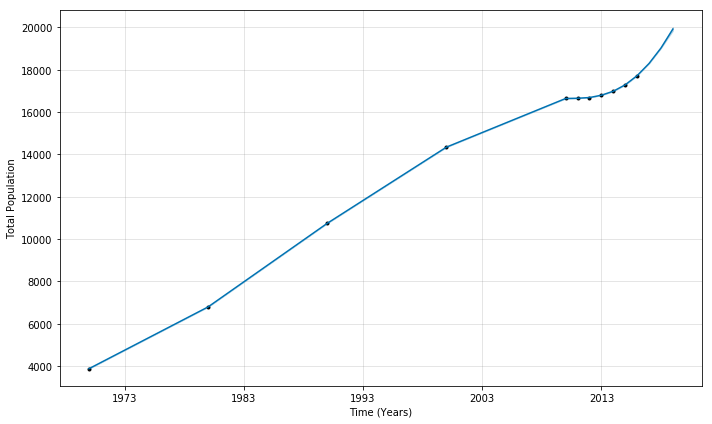

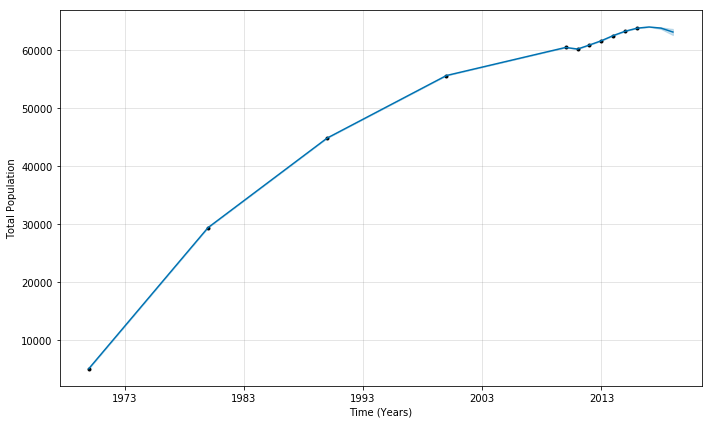

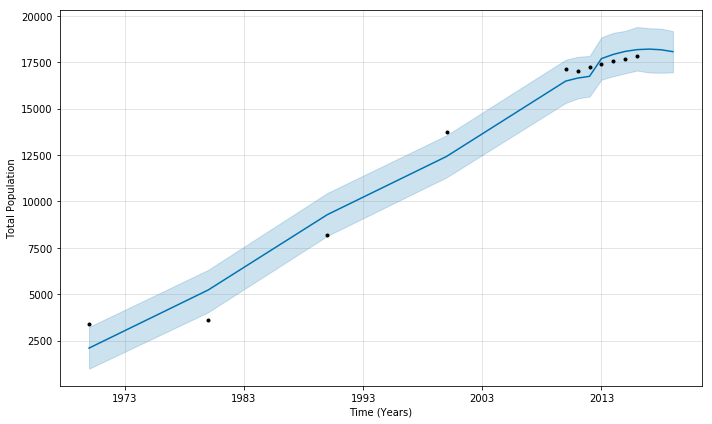

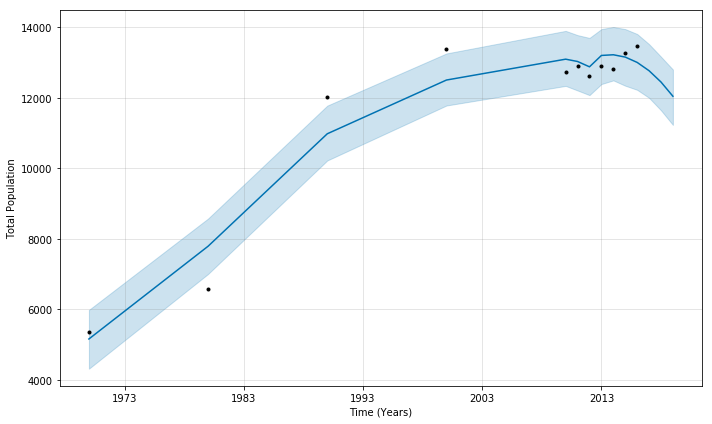

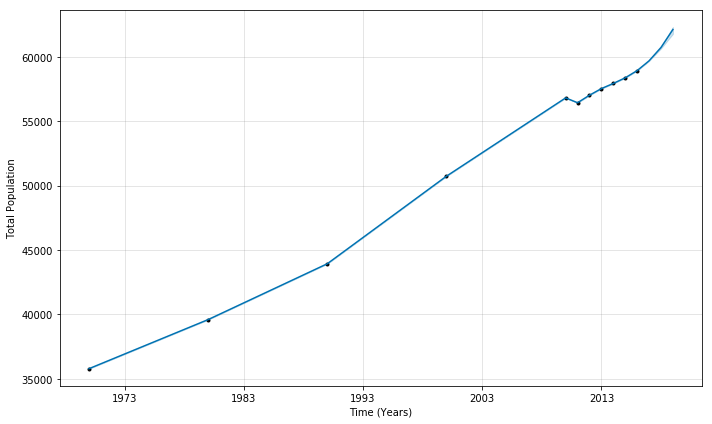

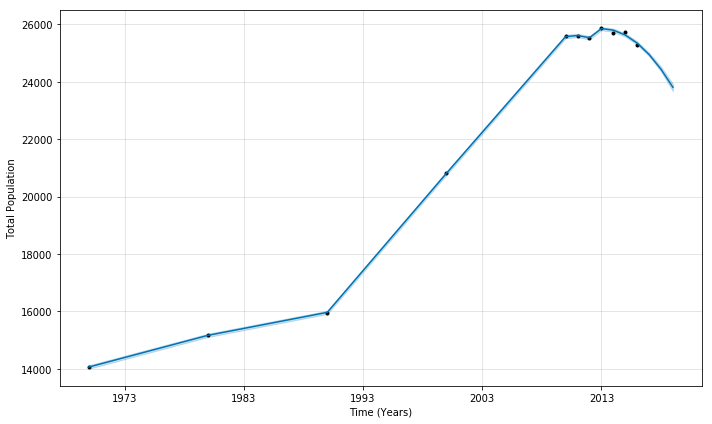

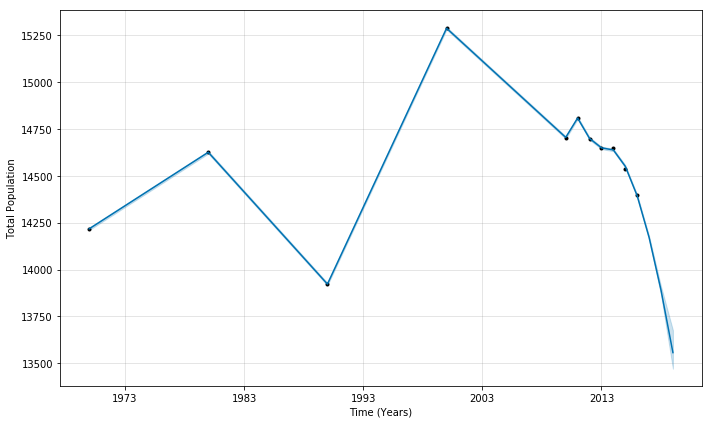

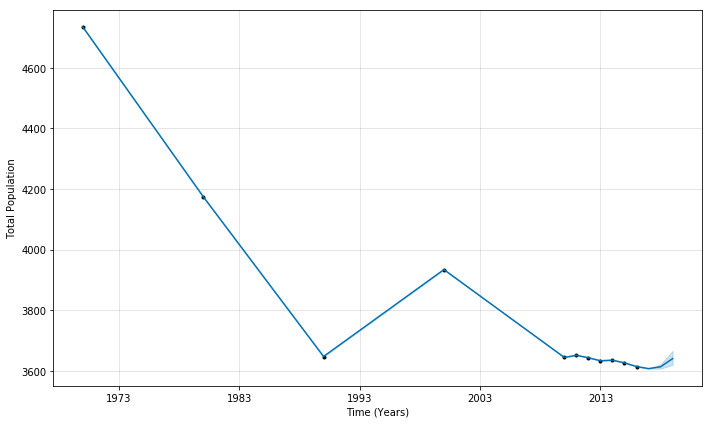

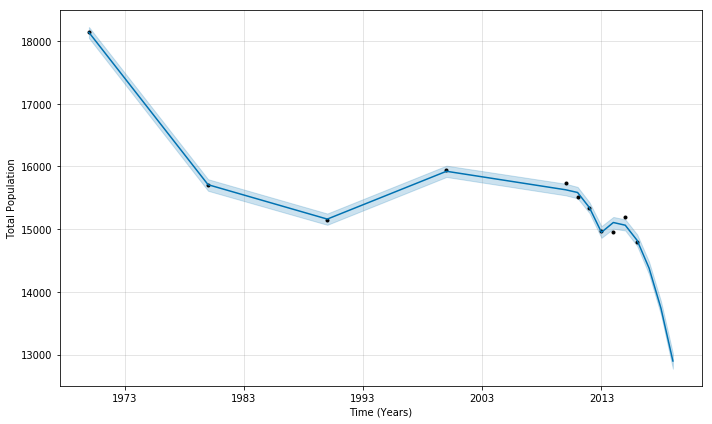

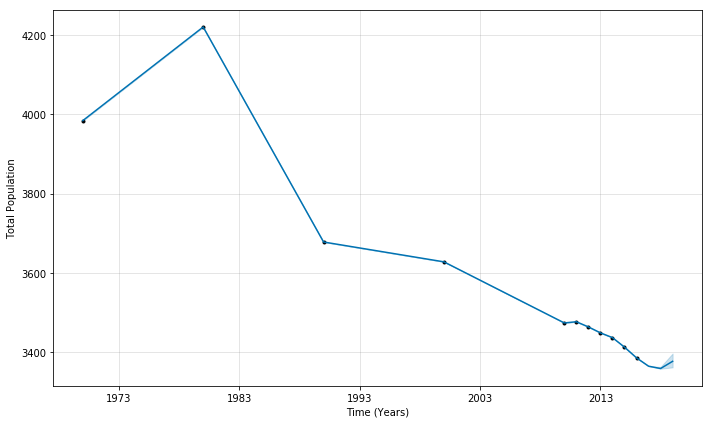

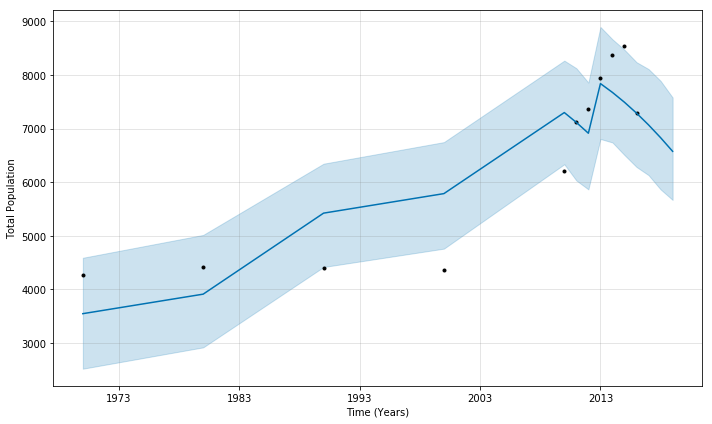

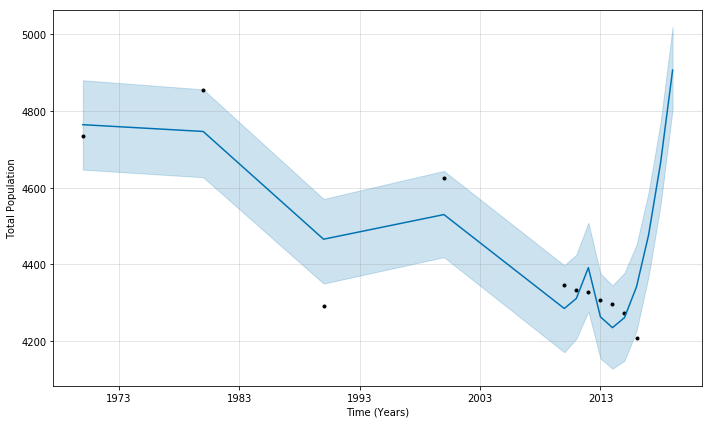

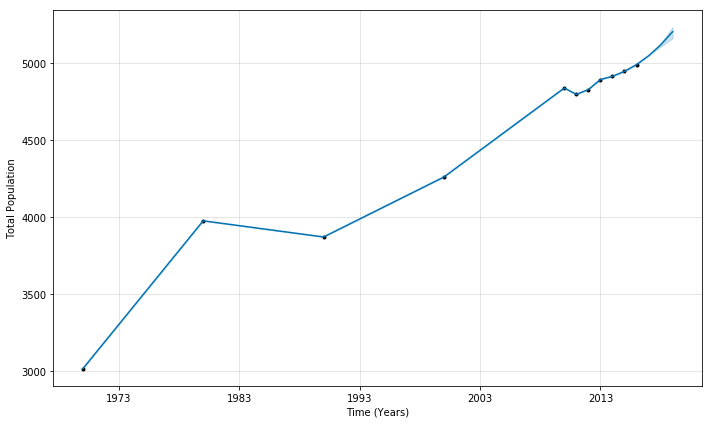

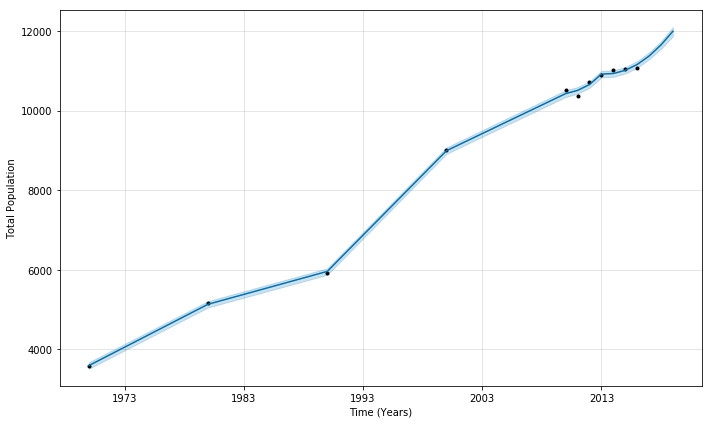

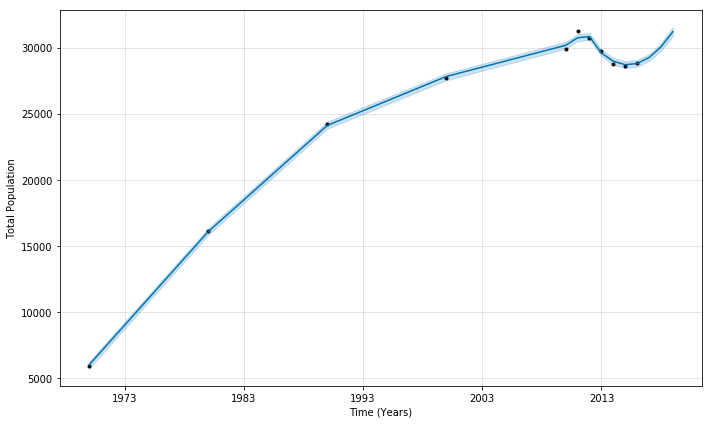

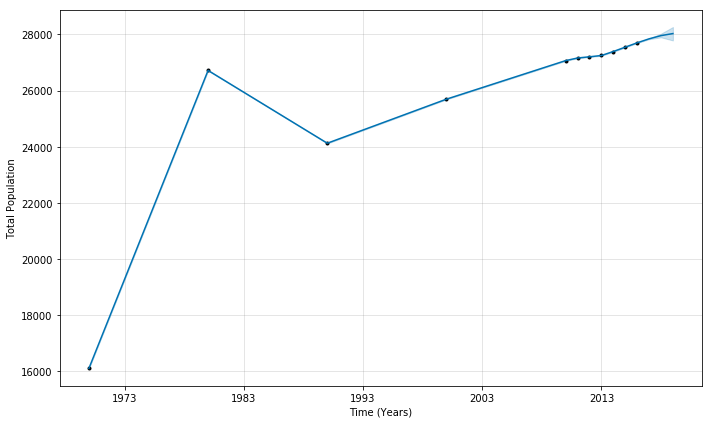

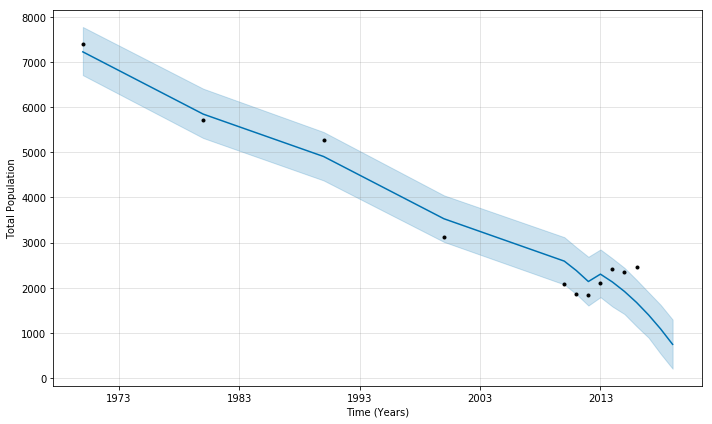

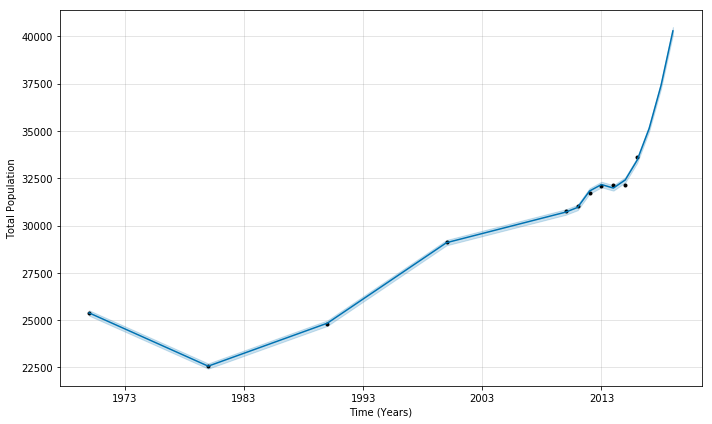

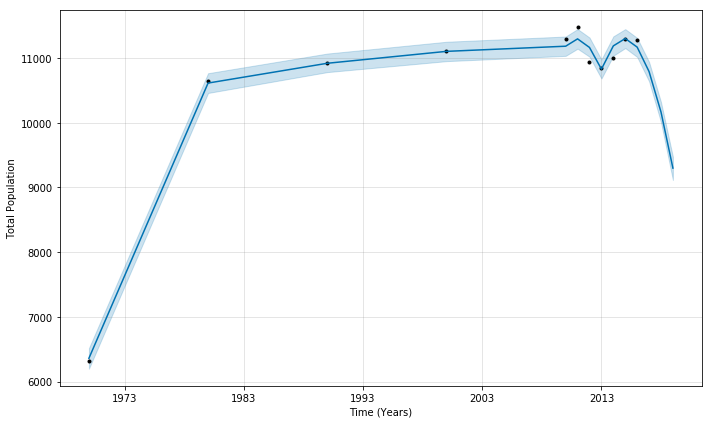

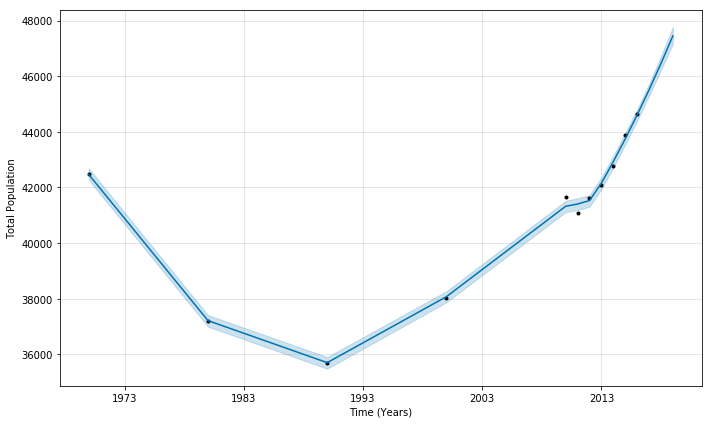

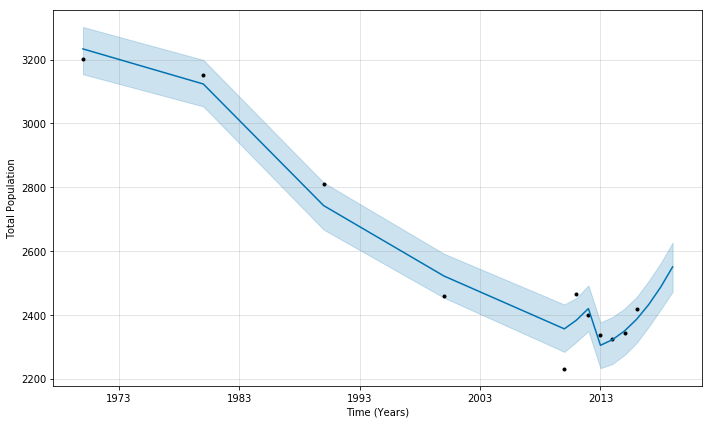

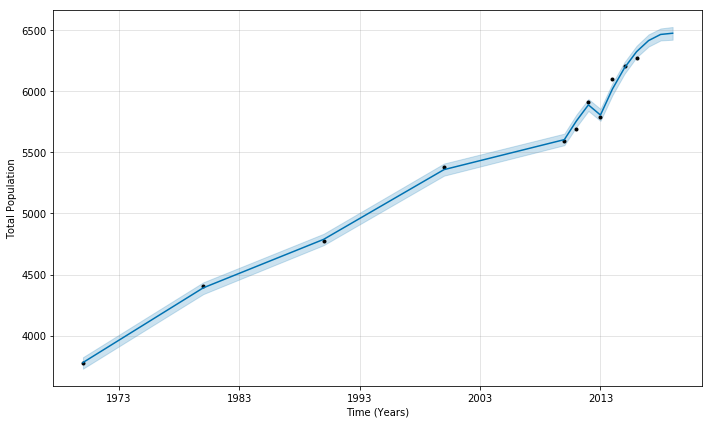

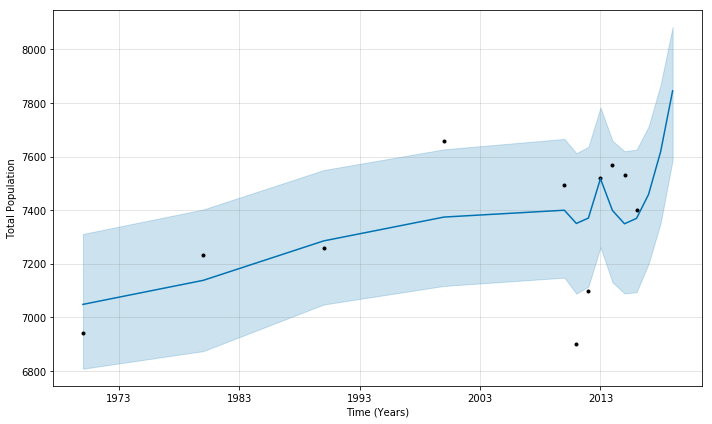

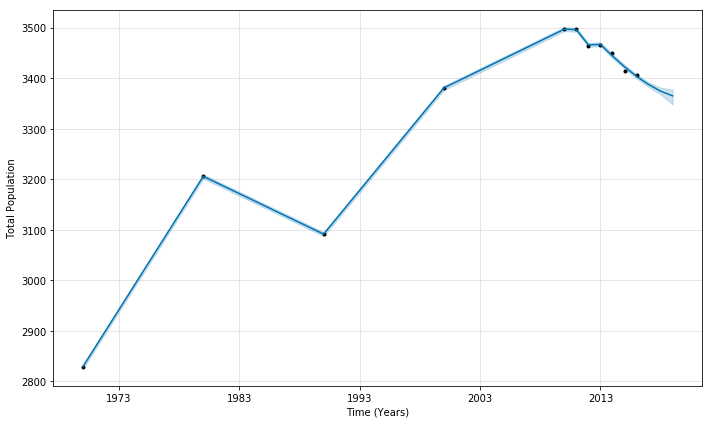

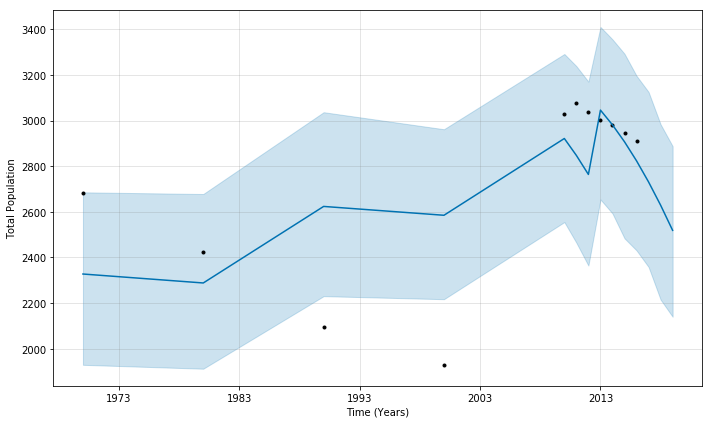

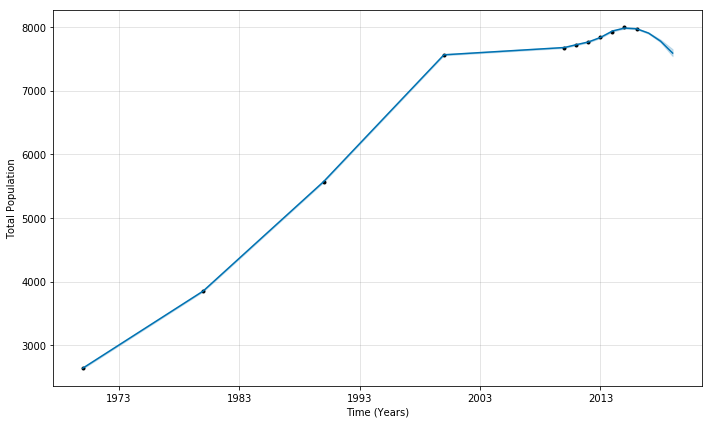

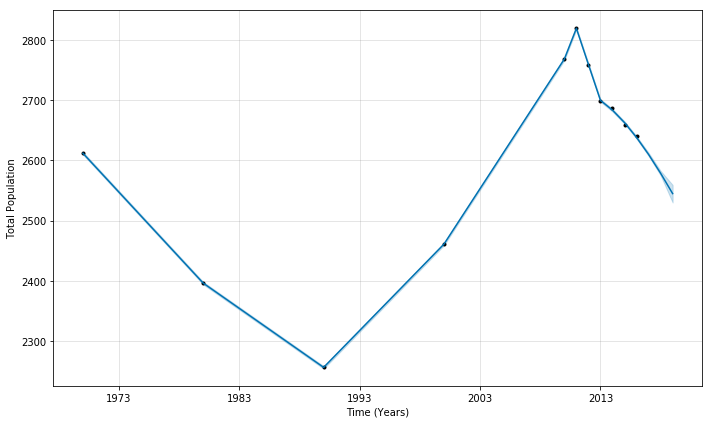

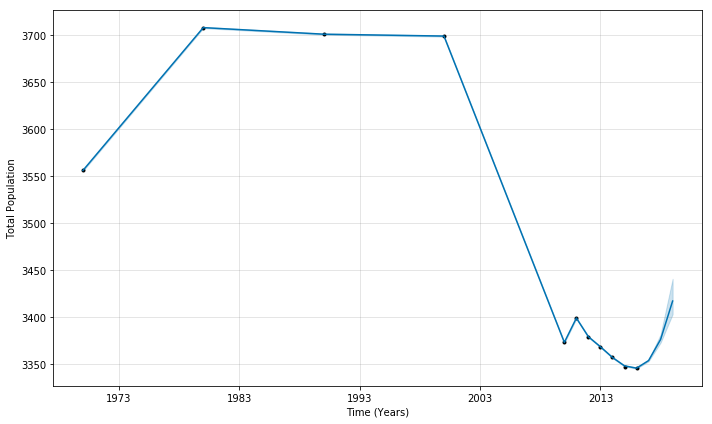

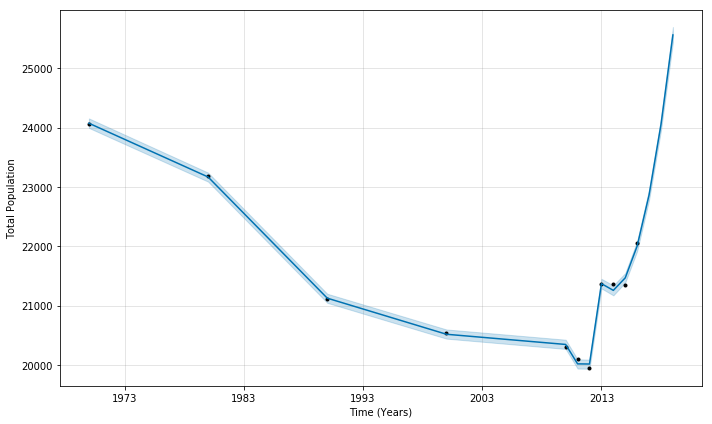

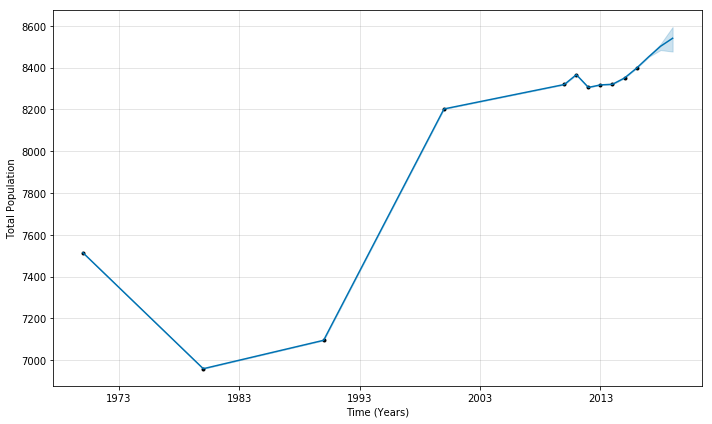

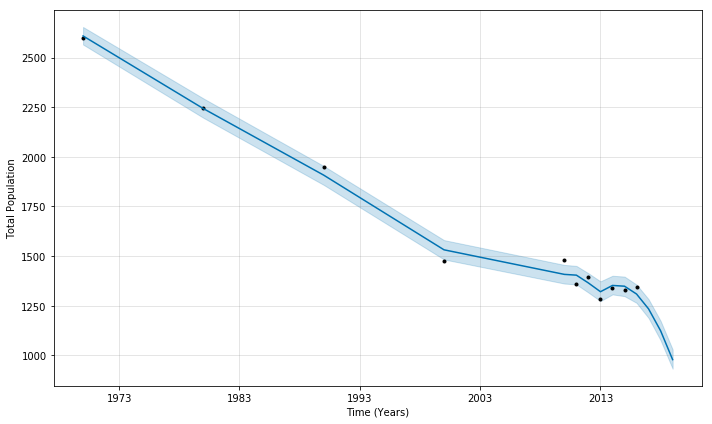

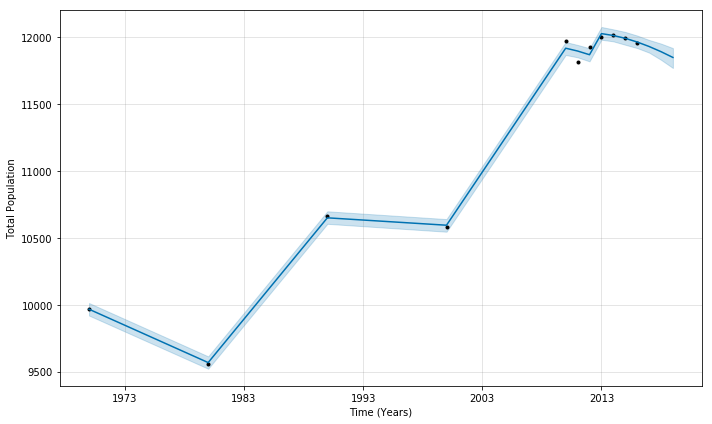

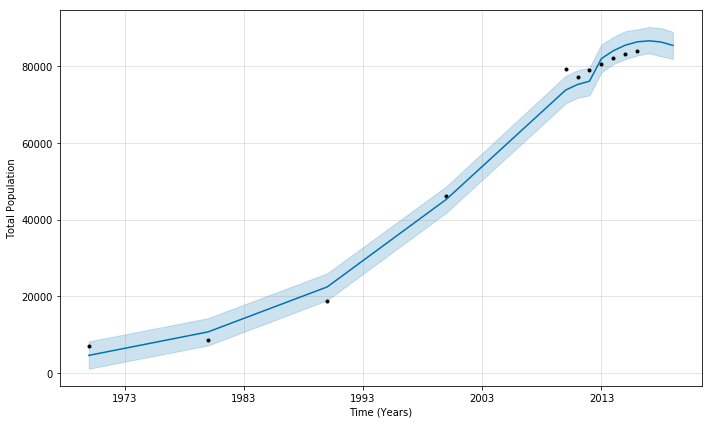

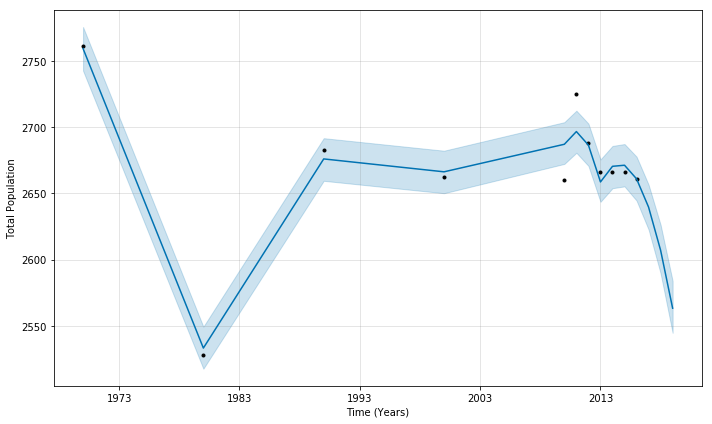

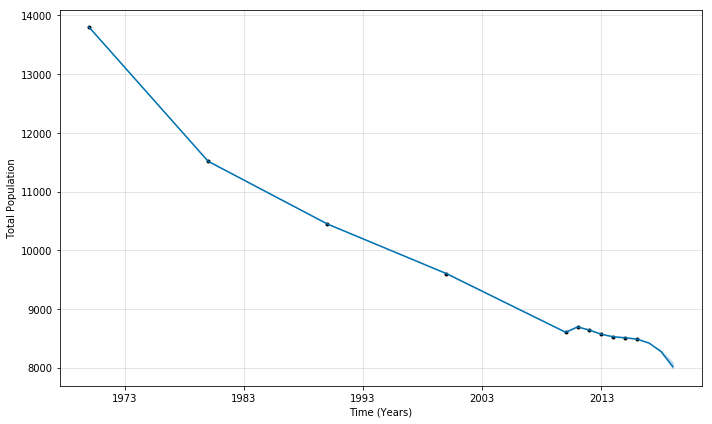

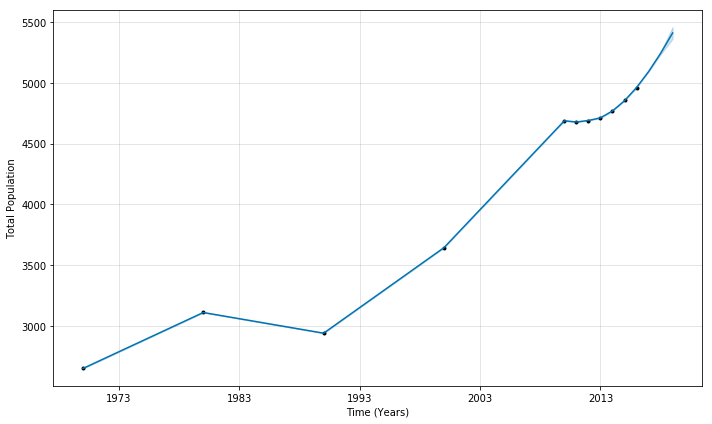

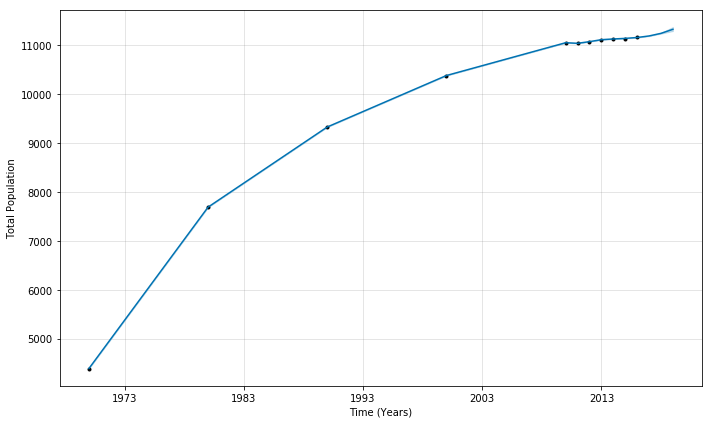

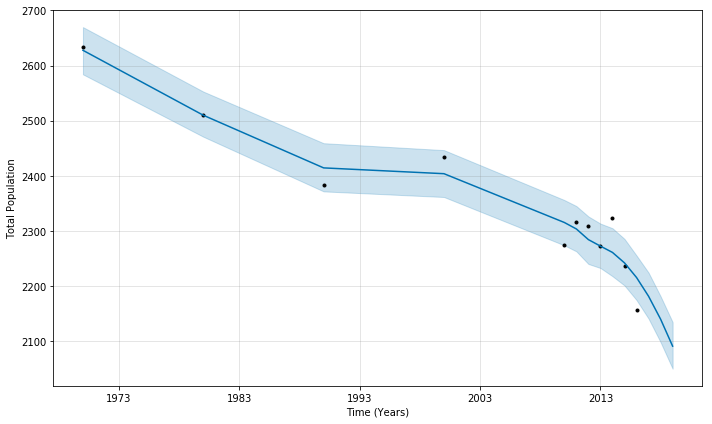

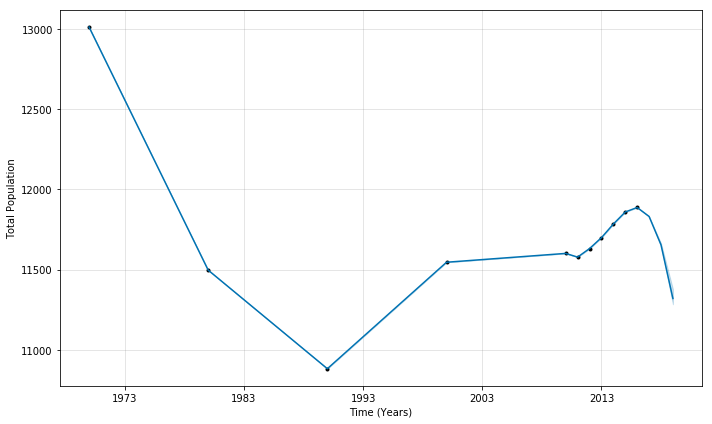

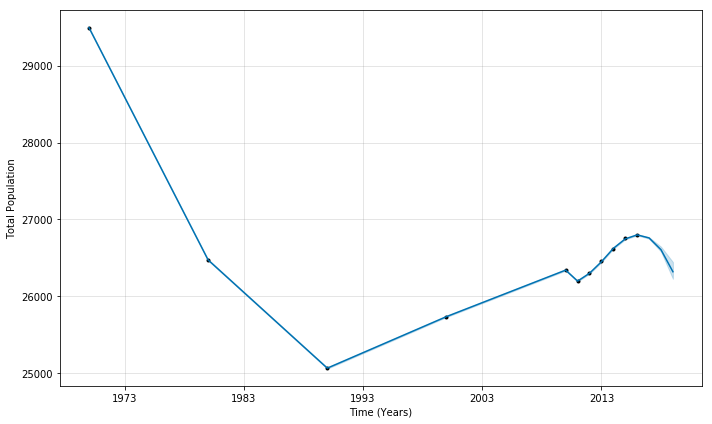

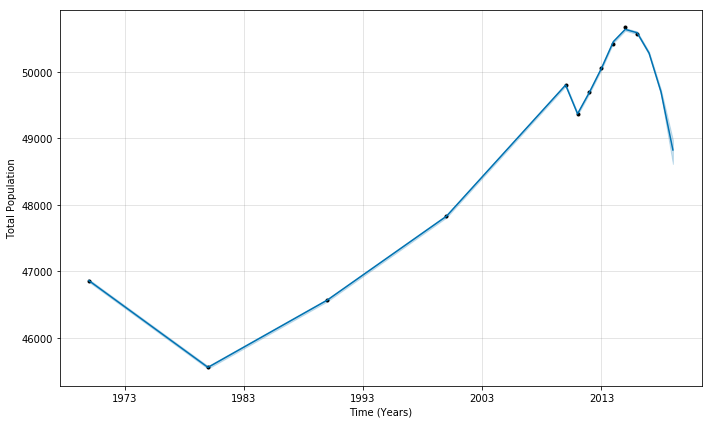

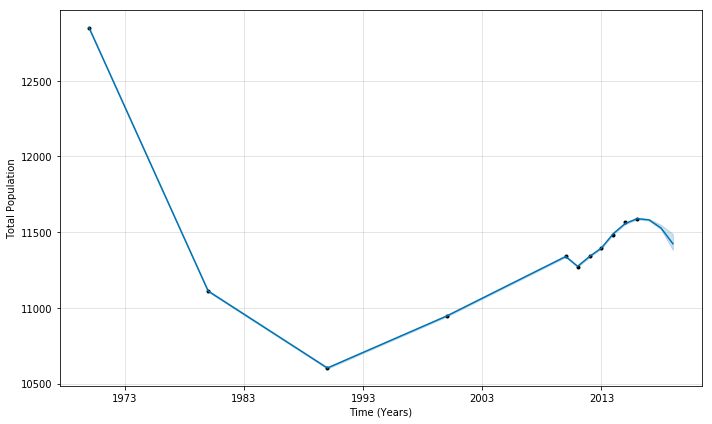

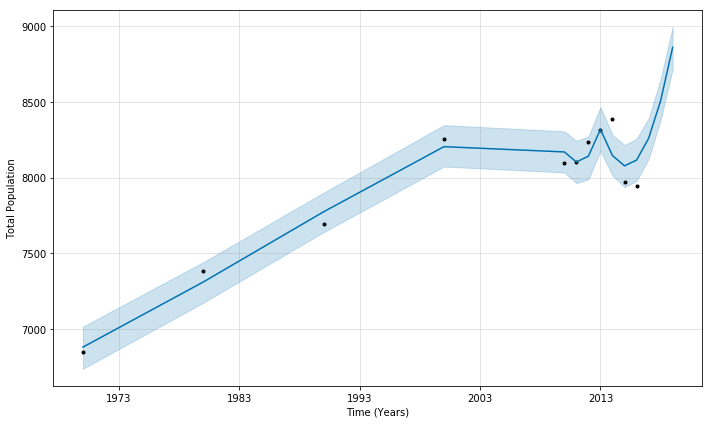

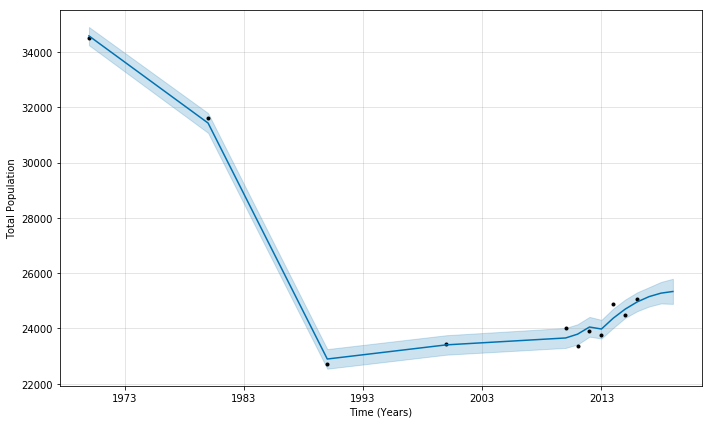

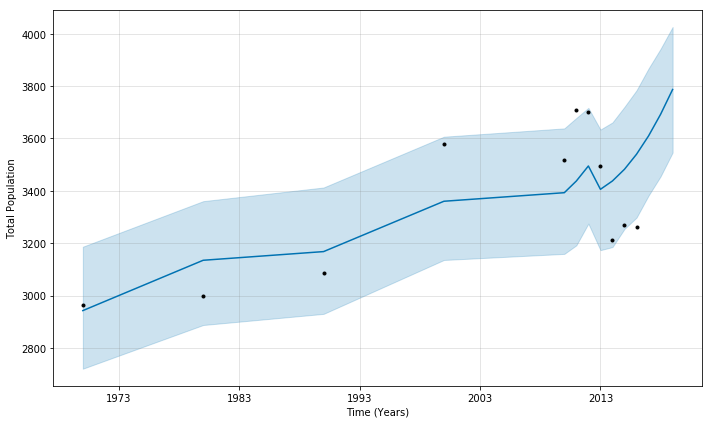

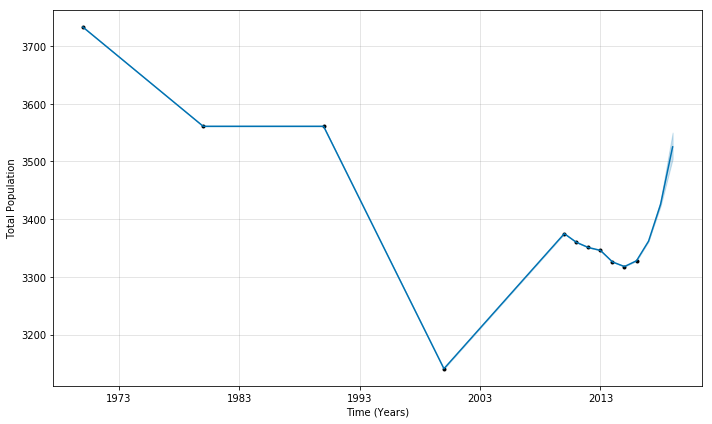

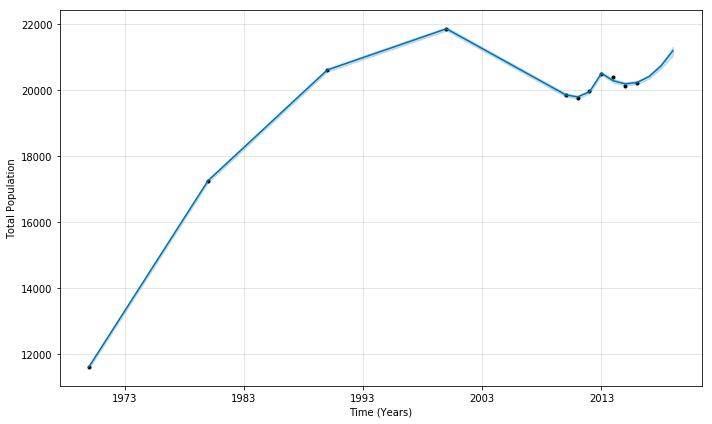

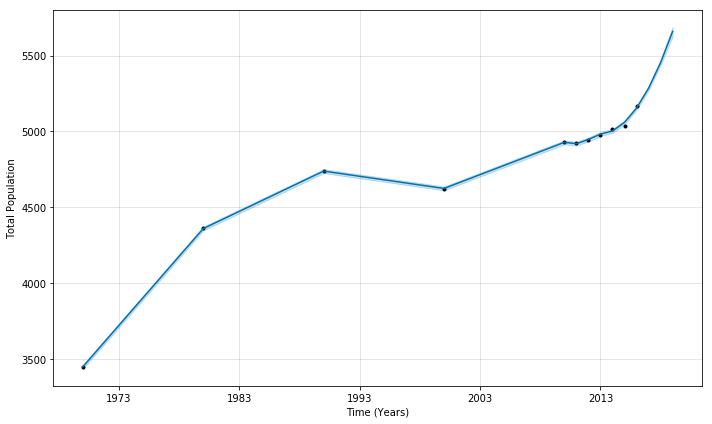

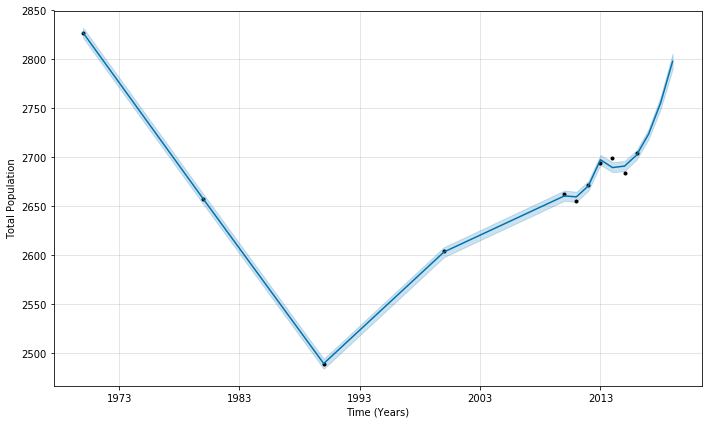

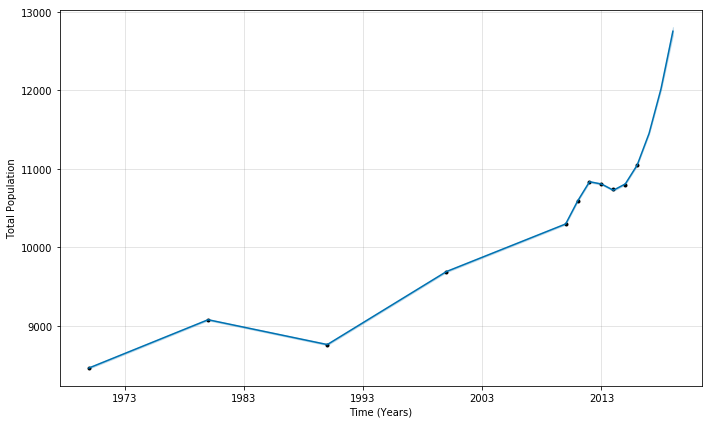

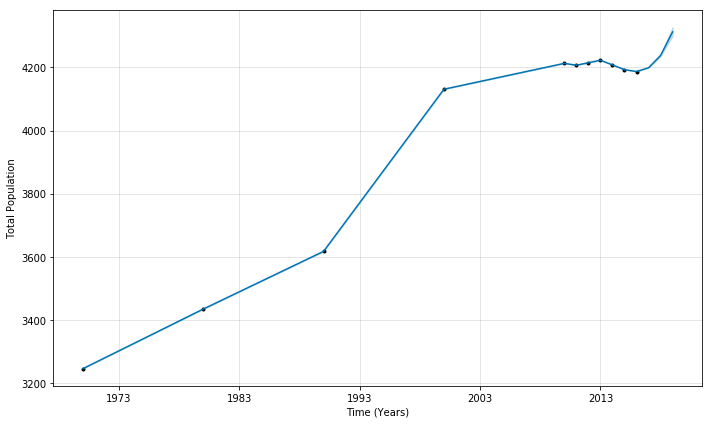

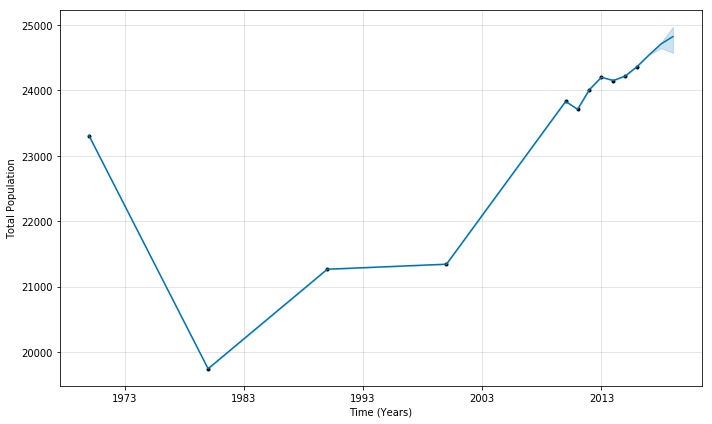

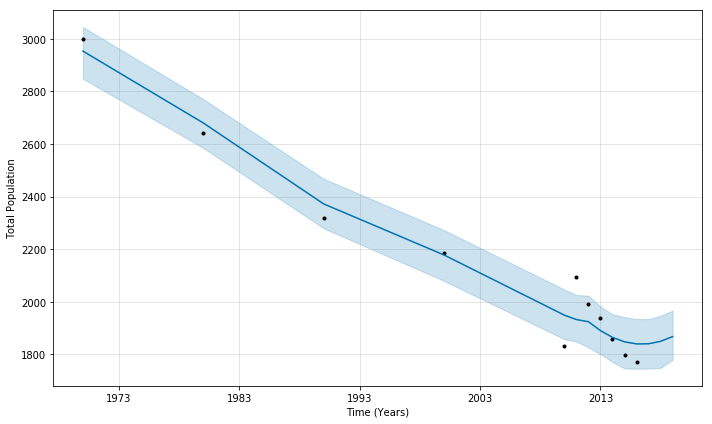

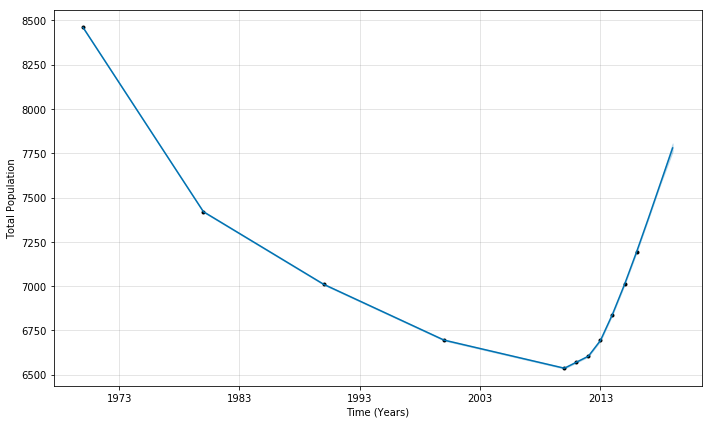

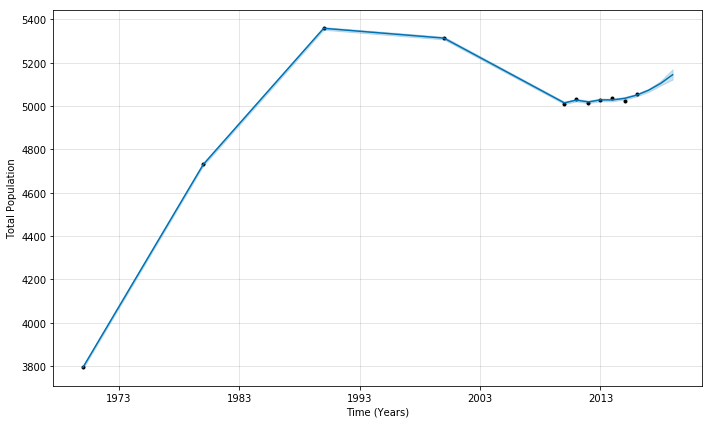

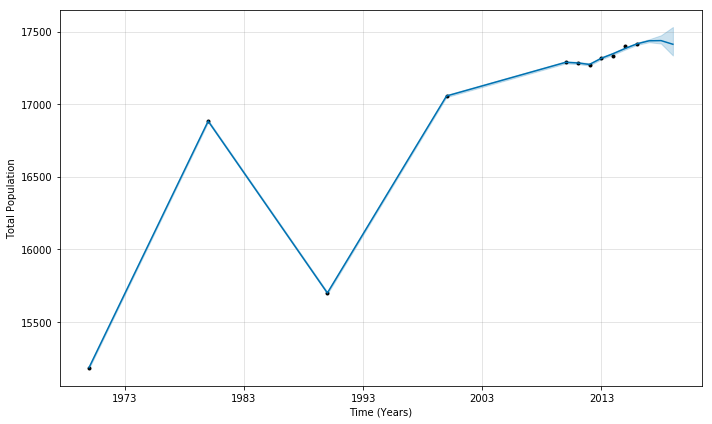

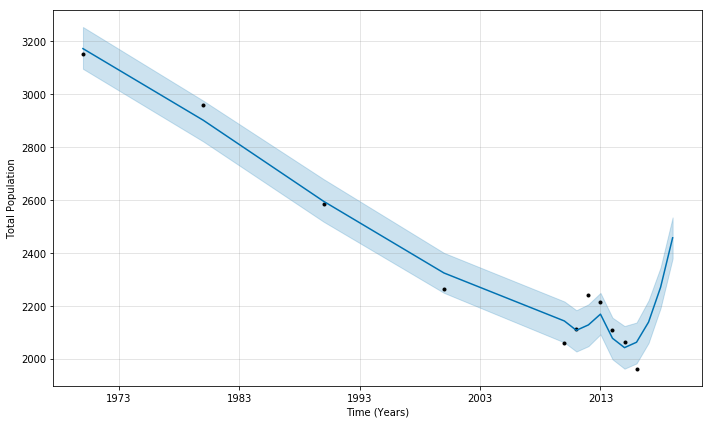

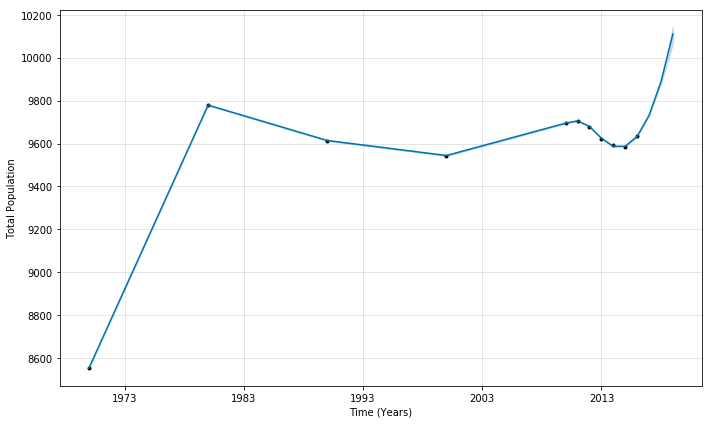

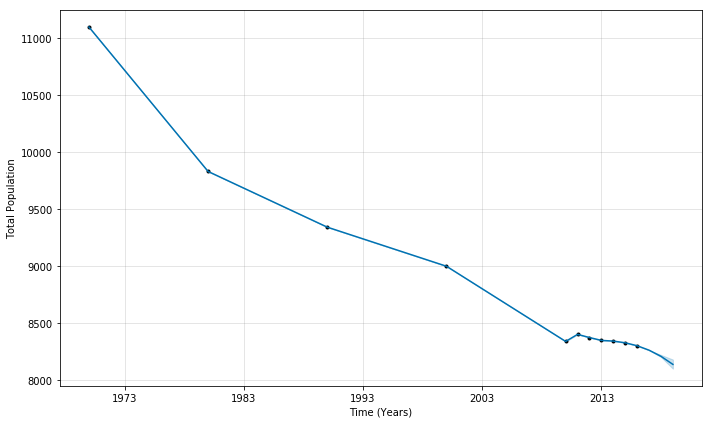

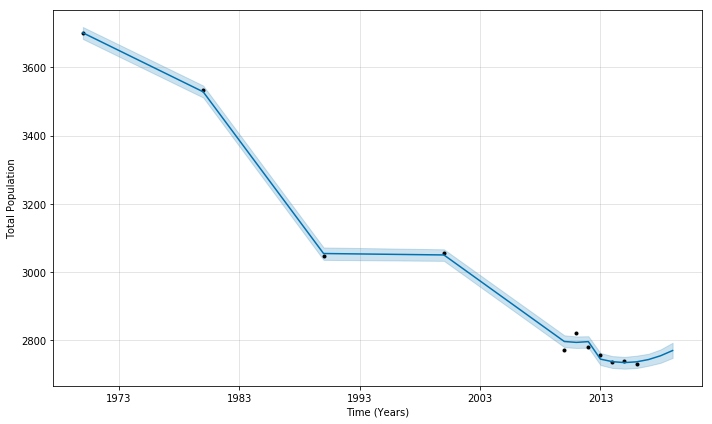

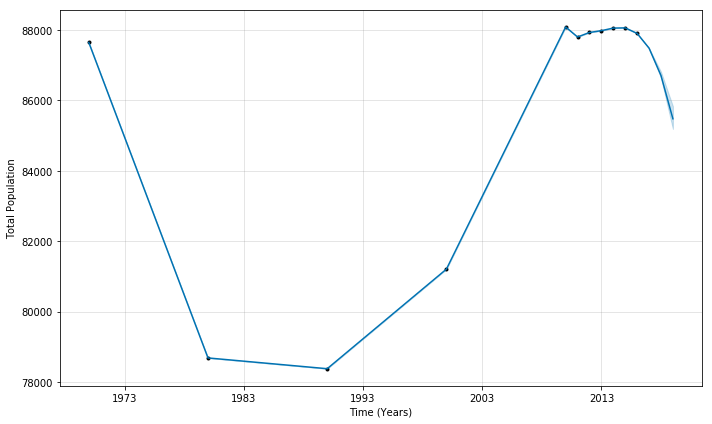

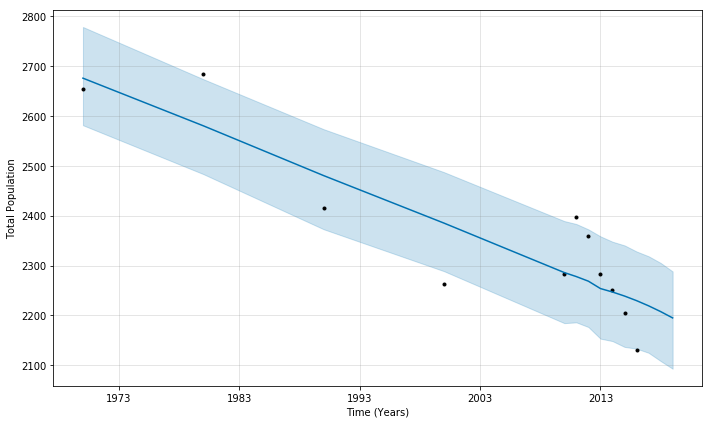

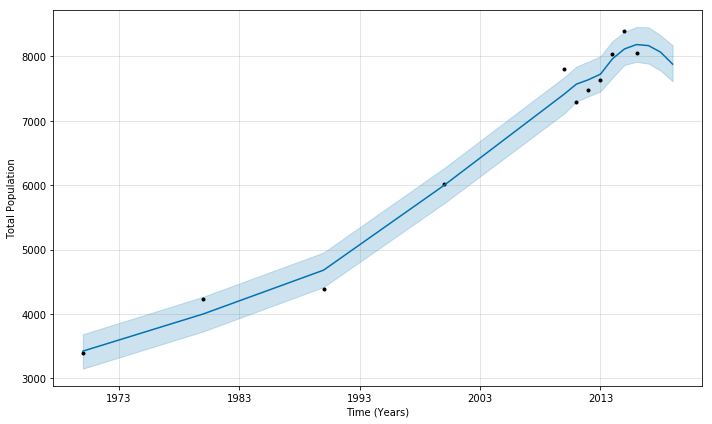

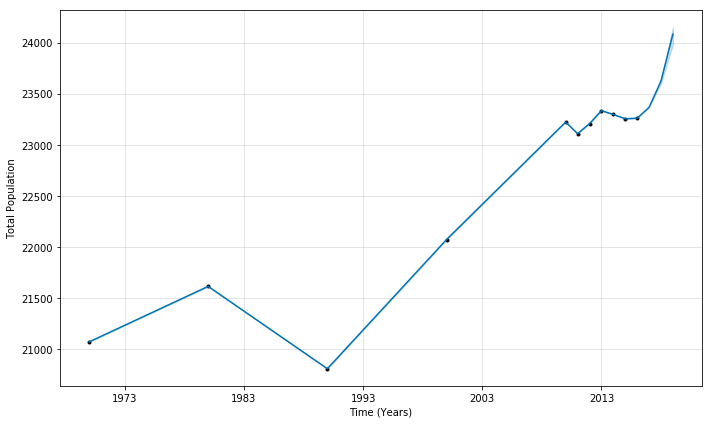

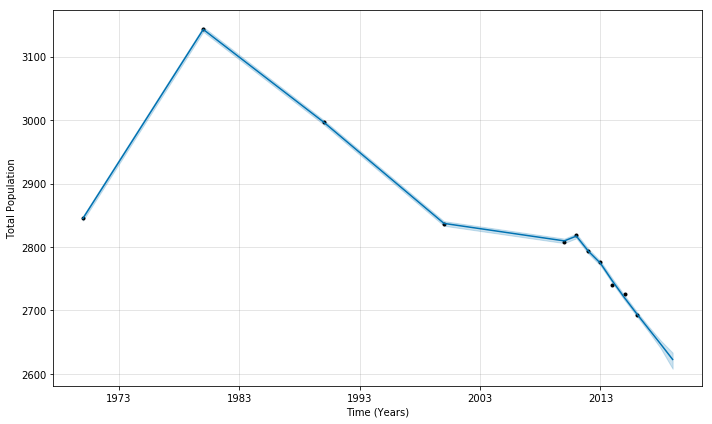

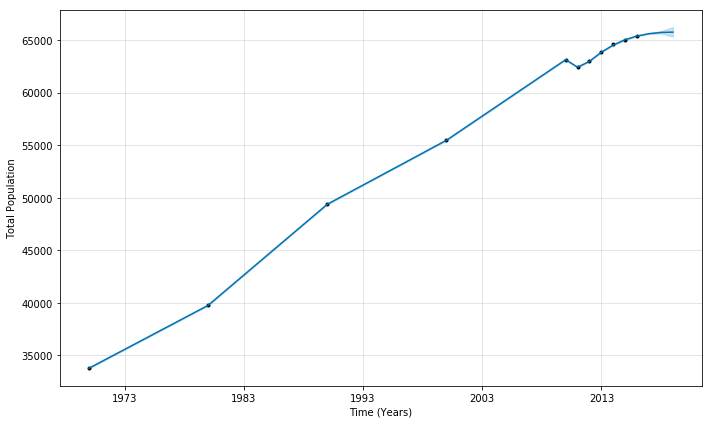

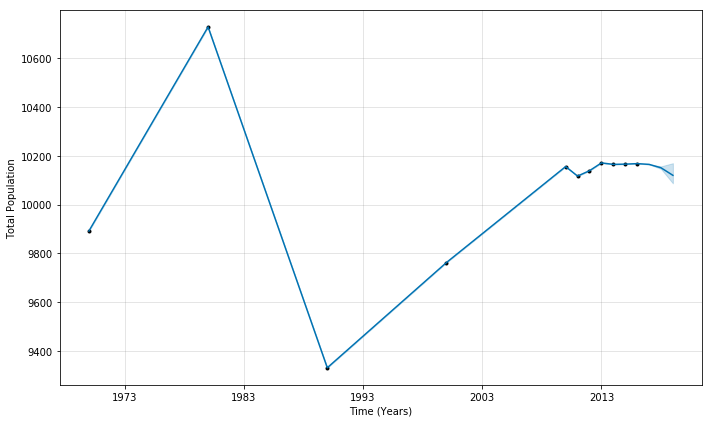

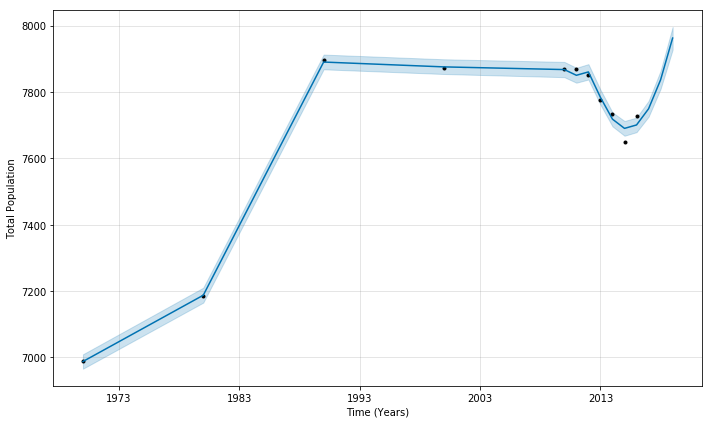

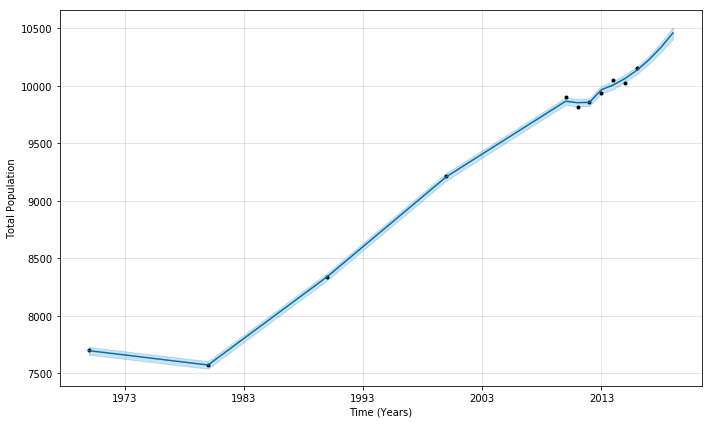

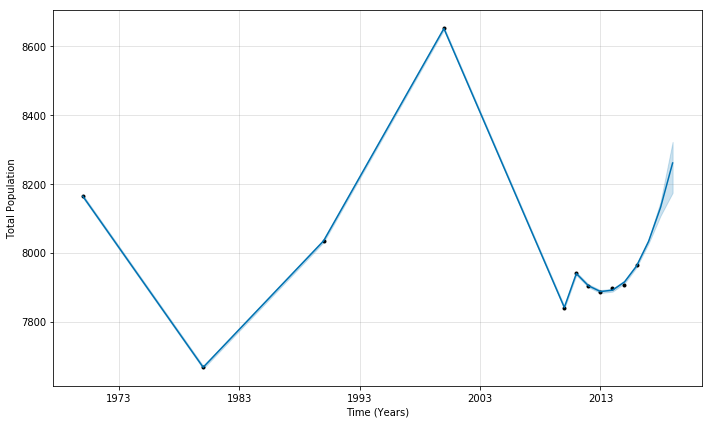

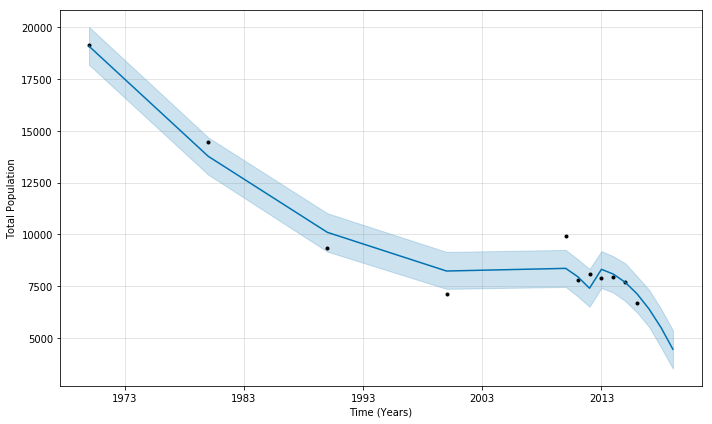

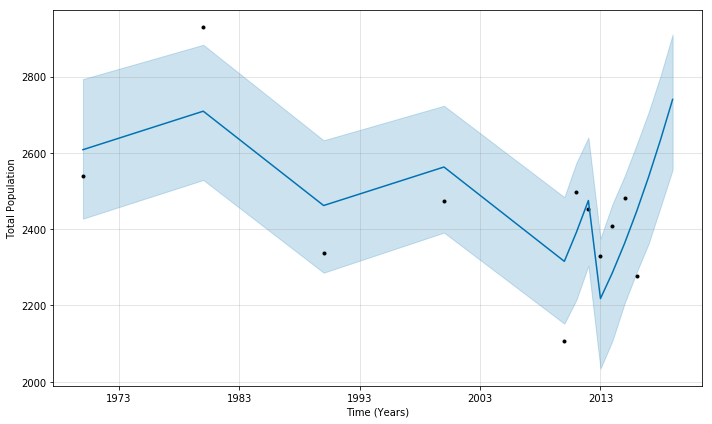

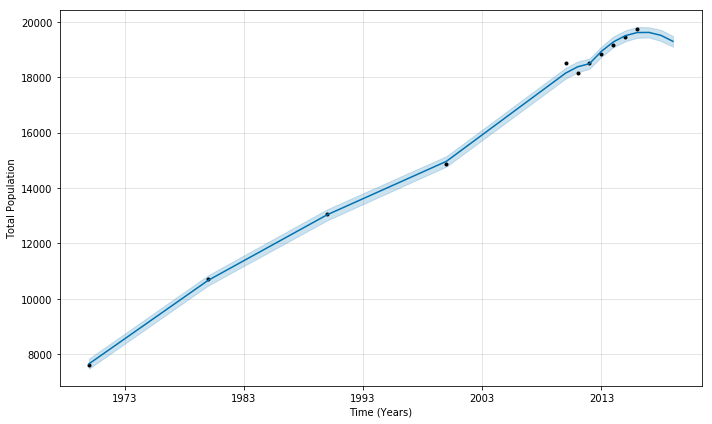

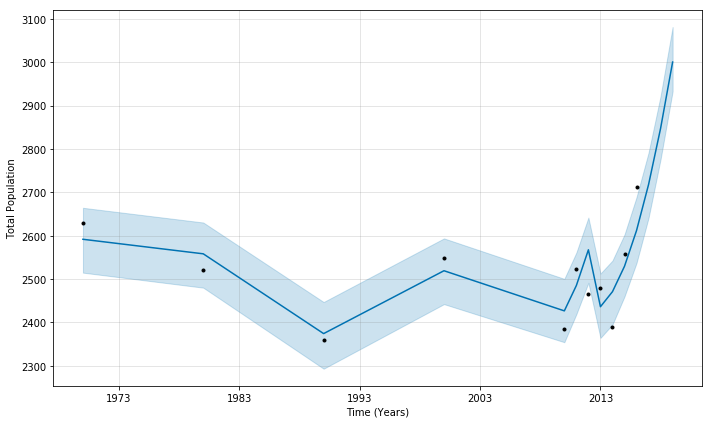

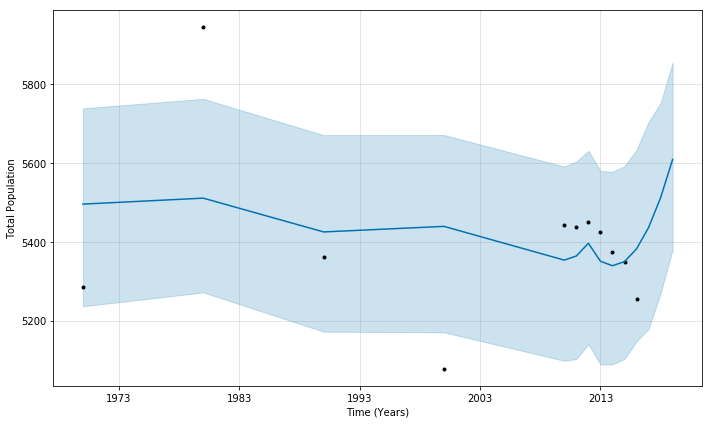

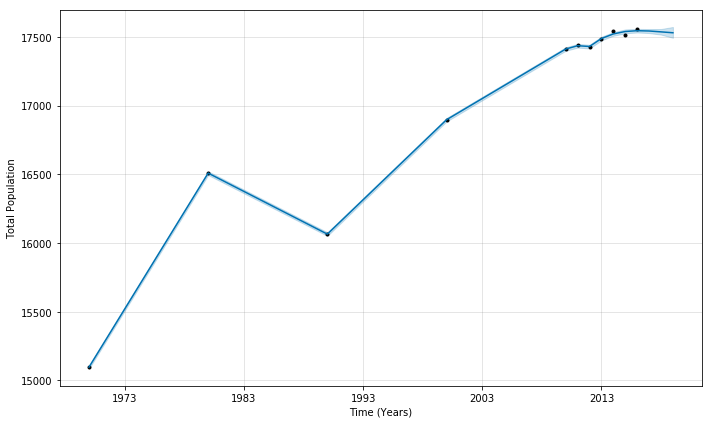

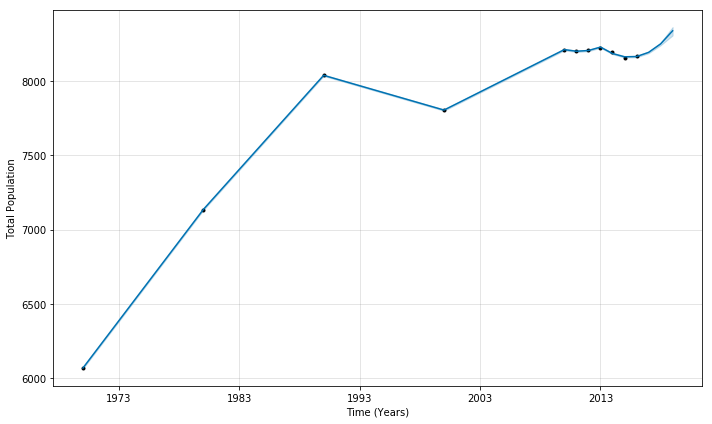

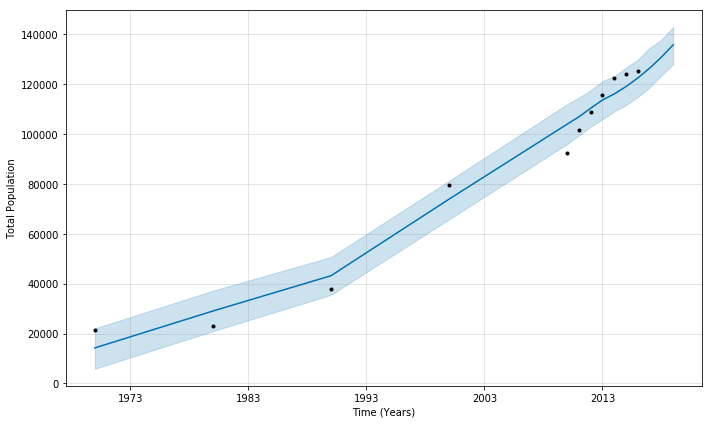

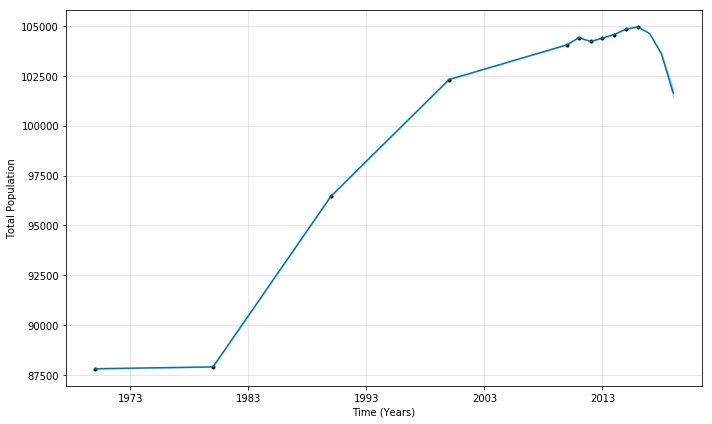

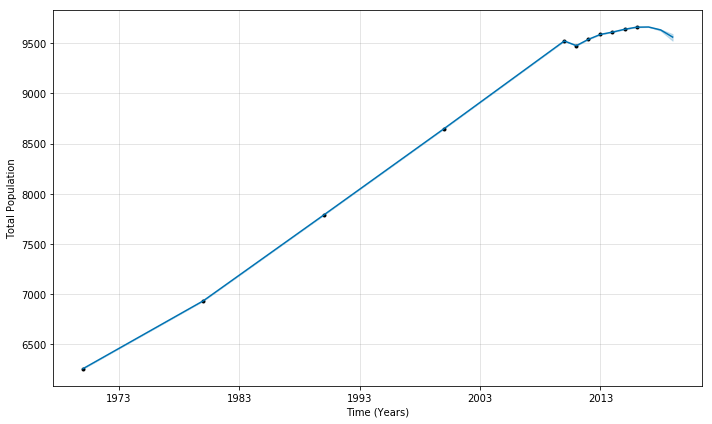

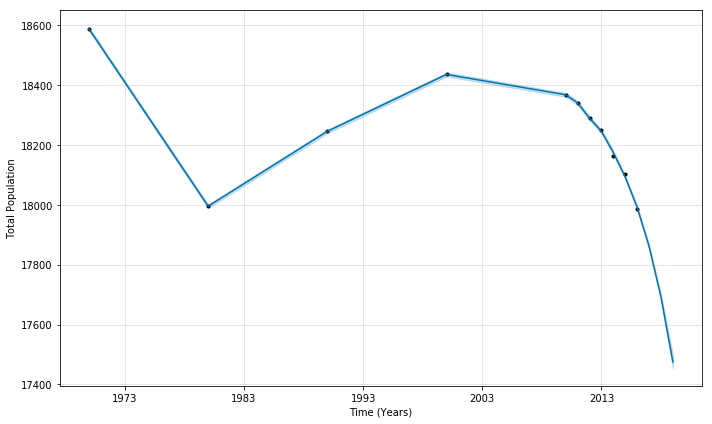

In [5]:
"""forecast 2016 and 2017 populations using model for each sample Place
"""
# set out route for forecast tables
forecasts = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# set out for plots
plots = []
# record cross vals
metrics=[]
# record prophets
prophets = []

# make DataFrame of column values as datetime (first converting to Series)
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=train_df.columns)))

# go though each place in train_df
for i in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[i]
    # add datetime values to forge place specific DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15,
                                      daily_seasonality=False,
                                      weekly_seasonality=False,
                                      yearly_seasonality=True,
                                      n_changepoints=10)
    
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    
    # fit place on prophet model 
    place_prophet.fit(df)
    
    # cross validate 
    df_cv = cross_validation(place_prophet, initial='14235 days', period='180 days', horizon = '365 days')
    # full metrics from crass validation
    df_p = performance_metrics(df_cv) 
    # add them to the list
    metrics.append(df_p)
    
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe(periods=3, 
                                                         freq='Y')
    
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # tag and bag (forecast table)
    forecasts.append(forecast)    
    # store 2016 and 2017 predictions
    train_preds.append([
        forecast.loc[forecast.ds == '2016-12-31'].yhat.values[0],
        forecast.loc[forecast.ds == '2017-12-31'].yhat.values[0]])
    
    # model plot the forecase
    m_plot = place_prophet.plot(forecast, 
                                ax=None, 
                                uncertainty=True, 
                                plot_cap=True, 
                                xlabel='Time (Years)', 
                                ylabel='Total Population')
    # add to plots
    plots.append(m_plot)

In [23]:
final_mape = [i.mape[12] for i in metrics]
avg_mape = np.mean(final_mape)
avg_mape

0.026423948845118048

In [42]:
'''make Baseline predictions of 2016 and 2017 population on sample Places'''
# set out route
baseline_preds = []
# go though each place in train_df
for j in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[j]
    # identify 2010 population
    p10 = float(df['2010'])
    # identify 2011 population
    p11 = float(df['2011'])
    # identify 2012 population
    p12 = float(df['2012'])
    # identify 2013 population
    p13 = float(df['2013'])
    # identify 2014 population
    p14 = float(df['2014'])
    # identify 2015 population
    p15 = float(df['2015'])
    # calculate average change over time for 2016
    avg_16_change = np.mean([abs(p15-p14),abs(p14-p13),abs(p13-p12),abs(p12-p11),abs(p11-p10)])
    # make 2016 prediction 
    p_16 = p15 + avg_16_change
    # calculate average change over time for 2017
    avg_17_change = np.mean([abs(p_16-p15), abs(p15-p14),abs(p14-p13),abs(p13-p12),abs(p12-p11)])
    # make 2017 prediction 
    p_17 = p_16 + avg_16_change
    # pair prediction, tag & bag
    baseline_preds.append([p_16,p_17])

In [88]:
'''make Baseline predictions of 2016 and 2017 population on sample Places'''
# set out route
baseline_preds = []
# go though each place in train_df
for j in range(len(train_df)):
    # extract DataFrame for that place
    df = train_df.iloc[j]
    # identify 2010 population
    p10 = float(df['2010'])
    # identify 2011 population
    p11 = float(df['2011'])
    # identify 2012 population
    p12 = float(df['2012'])
    # identify 2013 population
    p13 = float(df['2013'])
    # identify 2014 population
    p14 = float(df['2014'])
    # identify 2015 population
    p15 = float(df['2015'])
    # calculate average change over time for 2016
    avg_16_change = 0#np.max([(p15-p14),(p14-p13),(p13-p12),(p12-p11),(p11-p10)])
    # make 2016 prediction 
    p_16 = p15 + avg_16_change
    # calculate average change over time for 2017
    avg_17_change = 0#np.mean([(p_16-p15),(p15-p14),(p14-p13),(p13-p12),(p12-p11)])
    # make 2017 prediction 
    p_17 = p_16 + avg_16_change
    # pair prediction, tag & bag
    baseline_preds.append([p_16,p_17])

In [89]:
base_16_log_acc = np.log(sum([int(pred[0]) for pred in baseline_preds])/sum([int(act) for act in test_16_df]))
pred_16_log_acc = np.log(sum([pred[0] for pred in train_preds])/sum([int(act) for act in test_16_df]))
base_17_log_acc = np.log(sum([int(pred[1]) for pred in baseline_preds])/sum([int(act) for act in test_17_df]))
pred_17_log_acc = np.log(sum([pred[1] for pred in train_preds])/sum([int(act) for act in test_17_df]))
print(f"2016 Baseline = {base_16_log_acc}\n2016 Model = {pred_16_log_acc}\n\n2017 Baseline = {base_17_log_acc}\n2017 Model = {pred_17_log_acc}")

2016 Baseline = -0.004676734836489695
2016 Model = 0.004616483778066408

2017 Baseline = -0.008593562399576614
2017 Model = 0.0021729945461675085


In [92]:
base_16_sum_acc = sum([int(pred[0]) for pred in baseline_preds])/sum([int(act) for act in test_16_df])
pred_16_sum_acc = sum([pred[0] for pred in train_preds])/sum([int(act) for act in test_16_df])
base_17_sum_acc = sum([int(pred[1]) for pred in baseline_preds])/sum([int(act) for act in test_17_df])
pred_17_sum_acc = sum([pred[1] for pred in train_preds])/sum([int(act) for act in test_17_df])
print(f"2016 Baseline = {1-base_16_sum_acc}\n2016 Model = {1-pred_16_sum_acc}\n\n2017 Baseline = {1-base_17_sum_acc}\n2017 Model = {1-pred_17_sum_acc}")

2016 Baseline = 0.004665815940349982
2016 Model = -0.0046271561559361185

2017 Baseline = 0.008556743286819546
2017 Model = -0.0021753572098581753


In [47]:
'''pull actual measurements for 2016 and 2017 population for each sample Place'''
# actual populations for 2016
test_16 = [int(actual_population) for actual_population in test_16_df]
# actual populations for 2017
test_17 = [int(actual_population) for actual_population in test_17_df]

In [36]:
from statsmodels.stats.weightstats import ztest

In [50]:
actual_16 = [int(act) for act in test_16_df]
baseline_16 = [pred[0] for pred in baseline_preds]
model_16 = [pred[0] for pred in train_preds]

actual_17 = [int(act) for act in test_17_df]
baseline_17 = [pred[1] for pred in baseline_preds]
model_17 = [pred[1] for pred in train_preds]

In [48]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [53]:
o=[]
for i in range(len(actual_16)):
    o.append((abs(baseline_16[i]-actual_16[i]))/actual_16[i])
    
np.mean(o)

0.021227119077007927

In [8]:
test_16_df

GEO.display-label
La Fayette city, Alabama               2975
Oxford city, Alabama                  21202
San Carlos CDP, Arizona                4440
De Queen city, Arkansas                6657
North Little Rock city, Arkansas      66042
Cloverdale city, California            8763
Compton city, California              97740
Livingston city, California           13703
Muscoy CDP, California                13025
Patterson city, California            21205
San Clemente city, California         65082
San Lorenzo CDP, California           24790
San Rafael city, California           58948
Willowbrook CDP, California           22035
Yorba Linda city, California          67362
Lewes city, Delaware                   2955
Arcadia city, Florida                  7761
Frostproof city, Florida               3100
Port St. Joe city, Florida             3424
Punta Gorda city, Florida             17721
Tamarac city, Florida                 63747
St. Marys city, Georgia               17853
St. Simons CDP

In [9]:
test_17_df

GEO.display-label
La Fayette city, Alabama               2956.0
Oxford city, Alabama                  21231.0
San Carlos CDP, Arizona                4395.0
De Queen city, Arkansas                6623.0
North Little Rock city, Arkansas      66144.0
Cloverdale city, California            8810.0
Compton city, California              97847.0
Livingston city, California           13831.0
Muscoy CDP, California                12968.0
Patterson city, California            21497.0
San Clemente city, California         65226.0
San Lorenzo CDP, California           25101.0
San Rafael city, California           59180.0
Willowbrook CDP, California           22654.0
Yorba Linda city, California          67740.0
Lewes city, Delaware                   2961.0
Arcadia city, Florida                  7774.0
Frostproof city, Florida               3142.0
Port St. Joe city, Florida             3453.0
Punta Gorda city, Florida             18656.0
Tamarac city, Florida                 64262.0
St. Marys city, 

In [ ]:
# bentonville
# print(xvals[0])
# plots[0]
p_sixteen=out[0].loc[out[0].ds=='2016-12-31'].yhat
p_seventeen=out[0].loc[out[0].ds=='2017-12-31'].yhat
test_bville=test_df.loc[test_df.index == 'Bentonville city, Arkansas']
print([set(p_sixteen)][0])
print(test_bville['2016'][0])

In [ ]:
# pleasanton
print(xvals[1])
plots[1]

In [ ]:
out[1]

In [ ]:
# sfo
print(xvals[2])
plots[2]

In [ ]:
# nola
print(xvals[3])
plots[3]

In [ ]:
# sidney
print(xvals[4])
plots[4]

In [ ]:
# nyc
print(xvals[5])
plots[5]

In [ ]:
# houston
print(xvals[6])
plots[6]

In [ ]:
combined_df